<a href="https://colab.research.google.com/github/Theflawlessone/Deforestation-Biodiversity-Analysis/blob/main/notebooks/Deforestation_on_Biodiversity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Project Overview
**Link to Google drive to access datasets:** https://drive.google.com/drive/folders/1c84LaLj2T4c4EN0RzQPdmtAh3UoFJjux?usp=sharing  
<br>**Notes when running project**
- We formatted it so you can use the table of contents easily we have main sections labeled below
- Sometimes runs will get stuck on the line "test for species_richness compared to estimate in merged dataset" in the "mann-whitney u testing", not sure why but just go to "preprocessing & cleaning" and then under "creating/editing new datafames" its labeled "create new columns: species_richness and te_count_species" rerun that snippet and it will work that second time! <br>

**Table of Contents:**
- Loading Datasets
- Preprocessing & Cleaning
- Exploratory Data Analysis (EDA)
- Statistical Analysis
- Models

**Summary of Datasets/Column Names**
This is the biodiversity kaggle dataset, there is a parks.csv and species.csv: https://www.kaggle.com/datasets/nationalparkservice/park-biodiversity
Columns/Rows:
  <br>> **For parks.csv:**
- Park Code,
- Park Name,
- State,
- Acres,
- Latitude,
- Longitude
<br>> **For species.csv**
- Species id,
- Park name,
- Category (mammal, bird, etc),
- Order (scientific order specialty),
- Family,
- Scientific Name,
- Common name,
- Record status,
- Occurrence,
- Nativeness,
- Abundance,
- Seasonality,
- Conservation status.
We also add species_richness (count of native species per state) and count_te_species (count of threatened/endangered species) early on.

This is the deforestation dataset we found: https://research.fs.usda.gov/programs/fia?utm_source=#data-and-tools
it looks at different states over different years (total just means all inventory years combined),
then 'estimate' is the forest area change for that state/year in acres
next is 'variance' which is the squared standard error (smaller number means more confidence)
next is 'plot_count' which is the number of sample plots used (so bigger number would be better here)
then se is standard error estimate and percentage just helps you find that actual se amount in acres.


---


# Data Loading

Cells related to loading datasets (paths preserved).

##Loading datsets

###Importing nessecary libraries

In [14]:
!pip install pingouin
!pip install fuzzywuzzy
!pip install us

In [15]:
# Consolidated imports (auto-extracted)
import pandas as pd
import matplotlib.pyplot as plt
import re
import geopandas as gpd
import seaborn as sns
import folium
import requests  #our initial map outline
from IPython.display import display
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import kagglehub
import os, pandas as pd
import pingouin
import fuzzywuzzy
import us



# End of consolidated imports


###loading datasets and assigning names

In [16]:
!pip install gdown


# download from drive
!gdown 1g3IRypHA2EUwWaAkyD_-n7RzfLSJuXD5 -O parks.csv
!gdown 1Ya4KF7cCkYF7uRs67VNnGpJillBhA8e1 -O species.csv
!gdown 167-iGjrX0ox87N5eXVt-q_jzhtNsKQDY -O deforestation.csv

# load
parks = pd.read_csv("parks.csv")
species = pd.read_csv("species.csv")
deforestation = pd.read_csv("deforestation.csv")

print("Parks:", parks.shape)
print("Species:", species.shape)
print("Deforestation:", deforestation.shape)

Downloading...
From: https://drive.google.com/uc?id=1g3IRypHA2EUwWaAkyD_-n7RzfLSJuXD5
To: /content/parks.csv
100% 3.29k/3.29k [00:00<00:00, 8.50MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ya4KF7cCkYF7uRs67VNnGpJillBhA8e1
To: /content/species.csv
100% 17.5M/17.5M [00:00<00:00, 79.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=167-iGjrX0ox87N5eXVt-q_jzhtNsKQDY
To: /content/deforestation.csv
100% 39.9k/39.9k [00:00<00:00, 8.02MB/s]
Parks: (56, 6)
Species: (119248, 14)
Deforestation: (416, 7)


/tmp/ipython-input-1270348409.py:11: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  species = pd.read_csv("species.csv")


####weather dataset

In [18]:
#weather dataset
path = kagglehub.dataset_download("justinrwong/average-monthly-temperature-by-us-state")

# find CSV file inside the dataset folder
for file in os.listdir(path):
    if file.endswith(".csv"):
        weather_path = os.path.join(path, file)
        break

weather = pd.read_csv(weather_path)


In [19]:
#checking which states are in it, 48 states are in it not hawaii and alaska
print(weather[weather["state"].str.contains("Alaska", case=False)])
print(weather[weather["state"].str.contains("Hawaii", case=False)])


Empty DataFrame
Columns: [Unnamed: 0, month, year, state, average_temp, monthly_mean_from_1901_to_2000, centroid_lon, centroid_lat]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, month, year, state, average_temp, monthly_mean_from_1901_to_2000, centroid_lon, centroid_lat]
Index: []


###making sure import was successful

In [20]:
print("Weather:", weather.head(10))

Weather:    Unnamed: 0  month  year        state  average_temp  \
0           0      1  1950      Alabama          53.8   
1           1      1  1950      Arizona          39.6   
2           2      1  1950     Arkansas          45.6   
3           3      1  1950   California          39.4   
4           4      1  1950     Colorado          25.2   
5           5      1  1950  Connecticut          32.5   
6           6      1  1950     Delaware          42.0   
7           7      1  1950      Florida          64.4   
8           8      1  1950      Georgia          53.5   
9           9      1  1950        Idaho          20.4   

   monthly_mean_from_1901_to_2000  centroid_lon  centroid_lat  
0                            45.9    -86.828372     32.789832  
1                            41.1   -111.664418     34.293110  
2                            40.4    -92.439268     34.899745  
3                            42.7   -119.610699     37.246071  
4                            24.5   -105.54

In [21]:
print("Parks:", parks.head(10))

Parks:   Park Code                                   Park Name State   Acres  \
0      ACAD                        Acadia National Park    ME   47390   
1      ARCH                        Arches National Park    UT   76519   
2      BADL                      Badlands National Park    SD  242756   
3      BIBE                      Big Bend National Park    TX  801163   
4      BISC                      Biscayne National Park    FL  172924   
5      BLCA  Black Canyon of the Gunnison National Park    CO   32950   
6      BRCA                  Bryce Canyon National Park    UT   35835   
7      CANY                   Canyonlands National Park    UT  337598   
8      CARE                  Capitol Reef National Park    UT  241904   
9      CAVE              Carlsbad Caverns National Park    NM   46766   

   Latitude  Longitude  
0     44.35     -68.21  
1     38.68    -109.57  
2     43.75    -102.50  
3     29.25    -103.25  
4     25.65     -80.08  
5     38.57    -107.72  
6     37.57   

In [22]:
print("Species:", species.head(10))

Species:   Species ID             Park Name Category         Order      Family  \
0  ACAD-1000  Acadia National Park   Mammal  Artiodactyla    Cervidae   
1  ACAD-1001  Acadia National Park   Mammal  Artiodactyla    Cervidae   
2  ACAD-1002  Acadia National Park   Mammal     Carnivora     Canidae   
3  ACAD-1003  Acadia National Park   Mammal     Carnivora     Canidae   
4  ACAD-1004  Acadia National Park   Mammal     Carnivora     Canidae   
5  ACAD-1005  Acadia National Park   Mammal     Carnivora     Felidae   
6  ACAD-1006  Acadia National Park   Mammal     Carnivora     Felidae   
7  ACAD-1007  Acadia National Park   Mammal     Carnivora  Mephitidae   
8  ACAD-1008  Acadia National Park   Mammal     Carnivora  Mustelidae   
9  ACAD-1009  Acadia National Park   Mammal     Carnivora  Mustelidae   

          Scientific Name                                       Common Names  \
0             Alces alces                                              Moose   
1  Odocoileus virginianus  

In [23]:
print("Deforestation:", deforestation.head(10))

Deforestation:   INVENTORY_YEAR STATE_CODE      ESTIMATE      VARIANCE  PLOT_COUNT  \
0          Total      Total  8.671000e+07  1.311878e+10      114135   
1           2025      Total  7.325906e+04  5.094377e+07          95   
2           2024      Total  5.539804e+06  4.609719e+09        6884   
3           2023      Total  9.292361e+06  7.793832e+09       11052   
4           2022      Total  1.008284e+07  8.313889e+09       12805   
5           2021      Total  1.180935e+07  9.277511e+09       15544   
6           2020      Total  1.206263e+07  9.459020e+09       15969   
7           2019      Total  1.133330e+07  8.584997e+09       14918   
8           2018      Total  8.671880e+06  6.818620e+09       11325   
9           2017      Total  4.378821e+06  3.454059e+09        6066   

              SE  SE_PERCENT  
0  114537.258158    0.132092  
1    7137.490294    9.742809  
2   67894.909870    1.225583  
3   88282.684296    0.950057  
4   91180.529055    0.904314  
5   96319.835826 

###Check dataframe column datatypes

In [24]:
# weather.columns
# weather.dtypes

# parks.columns
# parks.dtypes

# species.columns
# species.dtypes

# deforestation.columns
# deforestation.dtypes

####%whos image

Downloading...
From: https://drive.google.com/uc?id=11oNNQE956jKJnIV2CjFYteQ_uOB7dnDZ
To: /content/whos.pdf
100% 579k/579k [00:00<00:00, 96.3MB/s]
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.11).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


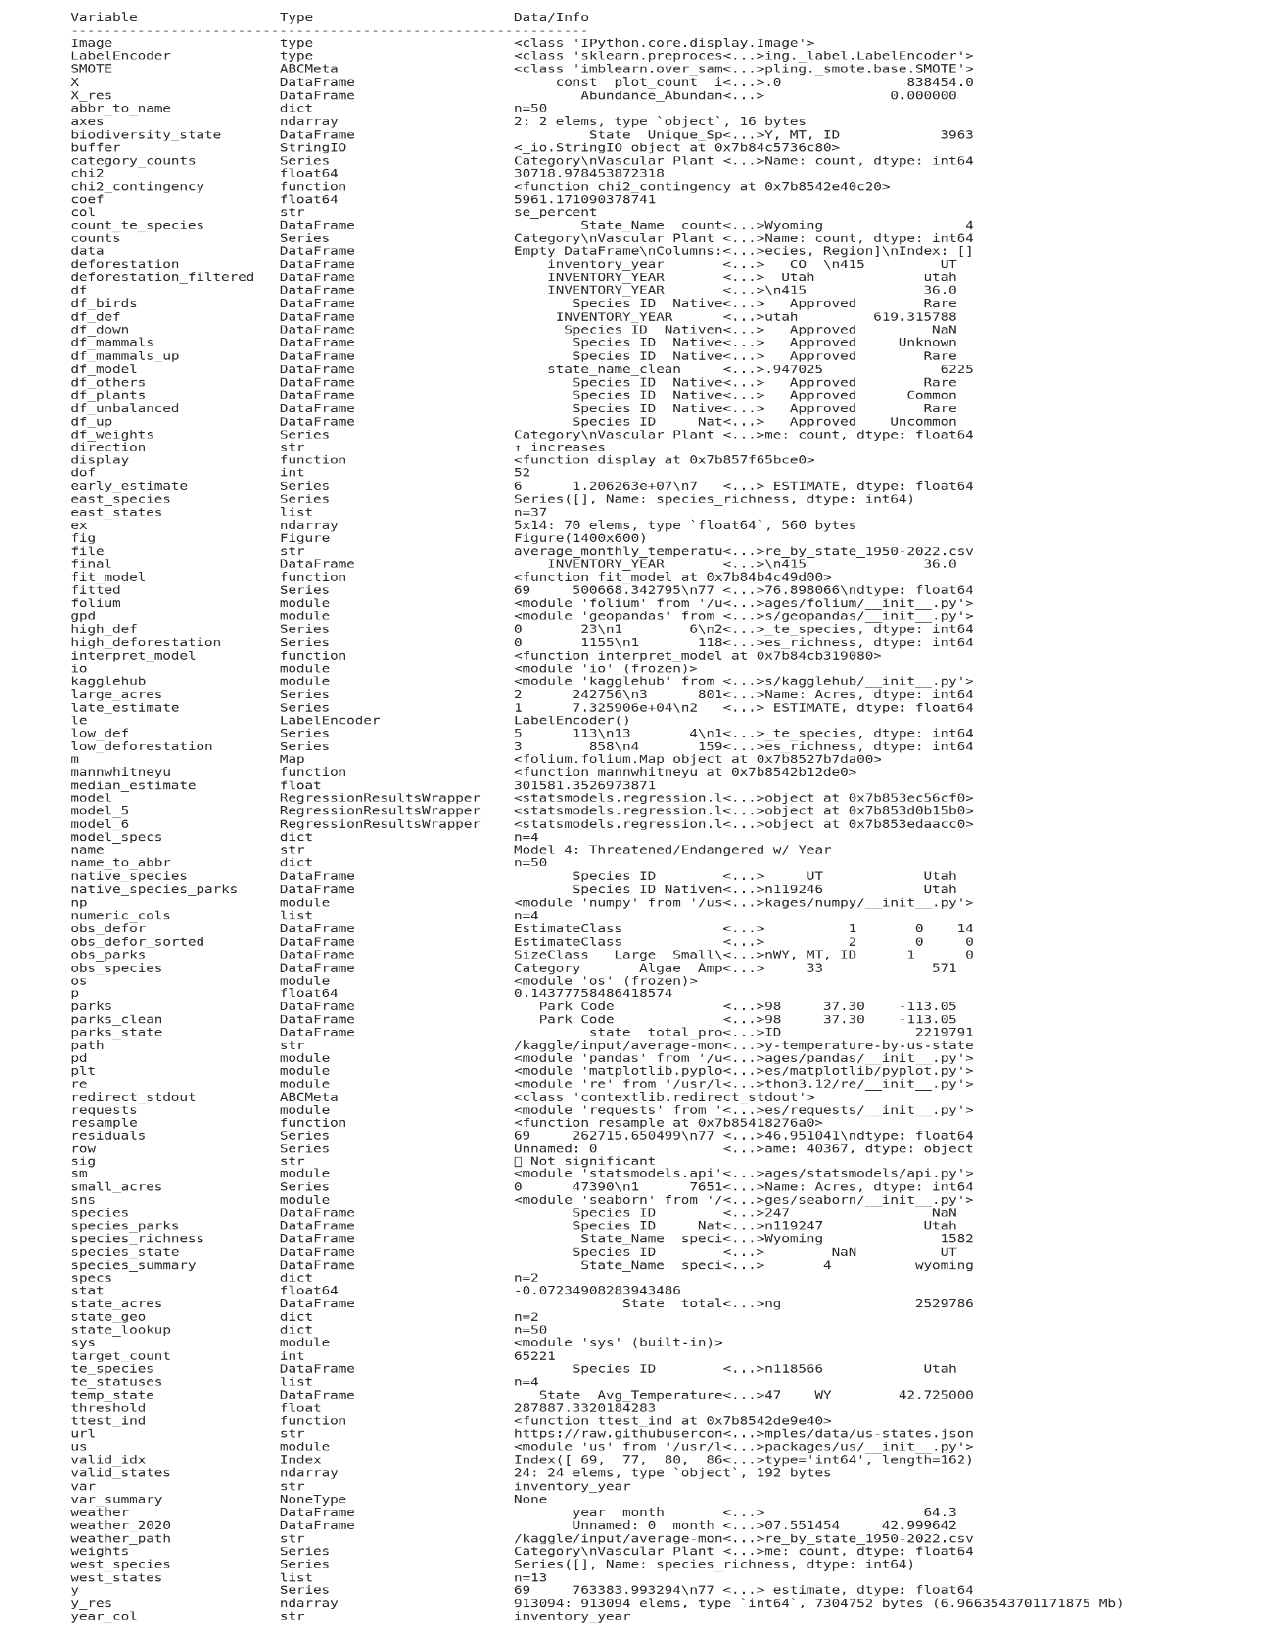

In [25]:
!gdown 11oNNQE956jKJnIV2CjFYteQ_uOB7dnDZ -O whos.pdf

!apt-get install -y poppler-utils  # only needs to run once
!pdftoppm whos.pdf whos -png

from IPython.display import Image
Image("whos-1.png")  # first page as image


### Mappings

#### Through matplot lib
<br>
Code below does not work due to the lack of federal funds on the website it is using (it was working now it is not) <br>
What is found when you go to the website: <br>
  NOTICE:
  Due to the lapse of federal funding, portions of this website will not be updated. Any inquiries submitted will not be answered until appropriations are enacted.

In [26]:
# US Census Bureau states shapefile (1:20m scale, includes states)
# url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"

# us_states = gpd.read_file(url)

# Merge with species_summary
# merged = us_states.merge(species_summary, left_on="NAME", right_on="State_Name", how="left")

# Plot
# merged.plot(column="Species_richness", cmap="viridis", legend=True, figsize=(12,6))
# plt.title("Species richness by State")
# plt.show(

####through Folium and requests

In [27]:
parks = pd.read_csv("parks.csv")
species = pd.read_csv("species.csv")

#merge species by park/state
species_state = species.merge(parks[["Park Name", "State"]], on="Park Name", how="left")

#count unique species per state
biodiversity_state = (
    species_state.groupby("State")["Scientific Name"] #state is 2 letter abbreviation
    .nunique()
    .reset_index()
    .rename(columns={"Scientific Name": "Unique_Species"})
)

# 3. Load US States GeoJSON
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

#map
m = folium.Map(location=[40, -95], zoom_start=4)

# Using Cloropleth
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=biodiversity_state,      #species per state
    columns=["State", "Unique_Species"],
    key_on="feature.id",       #match state abbreviation w state on map
    fill_color="YlGn",       #yellow/green scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Unique Species per State"
).add_to(m)

#markers
for _, row in parks.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=f"<b>{row['Park Name']}</b><br>State: {row['State']}<br>Acres: {row['Acres']:,}",  #to see park info
        icon=folium.Icon(color="green", icon="tree", prefix="fa")
    ).add_to(m)

#save
m.save("biodiversity_map.html")
display(m)

/tmp/ipython-input-1112999957.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  species = pd.read_csv("species.csv")


####average temp/year graph - 2019/2022

In [28]:
# --- 1. Filter for year 2019 ---
weather_2019 = weather[weather ["year"] == 2019]

# --- 2. Compute average temperature per state ---
temp_state = (
    weather_2019.groupby("state")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
)

# Optional: ensure state abbreviations
if len(temp_state["State"].iloc[0]) > 2:
    temp_state["State"] = temp_state["State"].map(
        lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
    )

# --- 3. Load US States GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 4. Create Folium map ---
m = folium.Map(location=[40, -95], zoom_start=4)

# --- 5. Add Choropleth layer ---
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=temp_state,
    columns=["State", "Avg_Temperature"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Average Temperature (°F) per State, 2019"
).add_to(m)

# --- 6. Optional: Add markers ---
for _, row in weather_2019.drop_duplicates("state").iterrows():
    folium.Marker(
        location=[row["centroid_lat"], row["centroid_lon"]],
        popup=f"<b>{row['state']}</b><br>Avg Temp: {row['average_temp']:.1f}°F",
        icon=folium.Icon(color="red", icon="thermometer-half", prefix="fa")
    ).add_to(m)

# --- 7. Save and show ---
m.save("temperature_map_2019.html")
display(m)

In [29]:
# --- 1. Filter for year 2020 ---
weather_2020 = weather[weather ["year"] == 2020]

# --- 2. Compute average temperature per state ---
temp_state = (
    weather_2020.groupby("state")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
)

# Optional: ensure state abbreviations
if len(temp_state["State"].iloc[0]) > 2:
    temp_state["State"] = temp_state["State"].map(
        lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
    )

# --- 3. Load US States GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 4. Create Folium map ---
m = folium.Map(location=[40, -95], zoom_start=4)

# --- 5. Add Choropleth layer ---
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=temp_state,
    columns=["State", "Avg_Temperature"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Average Temperature (°F) per State, 2020"
).add_to(m)

# --- 6. Optional: Add markers ---
for _, row in weather_2020.drop_duplicates("state").iterrows():
    folium.Marker(
        location=[row["centroid_lat"], row["centroid_lon"]],
        popup=f"<b>{row['state']}</b><br>Avg Temp: {row['average_temp']:.1f}°F",
        icon=folium.Icon(color="red", icon="thermometer-half", prefix="fa")
    ).add_to(m)

# --- 7. Save and show ---
m.save("temperature_map_2020.html")
display(m)


In [30]:
# --- 1. Filter for year 2021 ---
weather_2021 = weather[weather ["year"] == 2021]

# --- 2. Compute average temperature per state ---
temp_state = (
    weather_2021.groupby("state")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
)

# Optional: ensure state abbreviations
if len(temp_state["State"].iloc[0]) > 2:
    temp_state["State"] = temp_state["State"].map(
        lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
    )

# --- 3. Load US States GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 4. Create Folium map ---
m = folium.Map(location=[40, -95], zoom_start=4)

# --- 5. Add Choropleth layer ---
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=temp_state,
    columns=["State", "Avg_Temperature"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Average Temperature (°F) per State, 2021"
).add_to(m)

# --- 6. Optional: Add markers ---
for _, row in weather_2021.drop_duplicates("state").iterrows():
    folium.Marker(
        location=[row["centroid_lat"], row["centroid_lon"]],
        popup=f"<b>{row['state']}</b><br>Avg Temp: {row['average_temp']:.1f}°F",
        icon=folium.Icon(color="red", icon="thermometer-half", prefix="fa")
    ).add_to(m)

# --- 7. Save and show ---
m.save("temperature_map_2021.html")
display(m)

In [31]:
# --- 1. Filter for year 2022 ---
weather_2022 = weather[weather ["year"] == 2022]

# --- 2. Compute average temperature per state ---
temp_state = (
    weather_2022.groupby("state")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
)

# Optional: ensure state abbreviations
if len(temp_state["State"].iloc[0]) > 2:
    temp_state["State"] = temp_state["State"].map(
        lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
    )

# --- 3. Load US States GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 4. Create Folium map ---
m = folium.Map(location=[40, -95], zoom_start=4)

# --- 5. Add Choropleth layer ---
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=temp_state,
    columns=["State", "Avg_Temperature"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Average Temperature (°F) per State, 2022"
).add_to(m)

# --- 6. Optional: Add markers ---
for _, row in weather_2020.drop_duplicates("state").iterrows():
    folium.Marker(
        location=[row["centroid_lat"], row["centroid_lon"]],
        popup=f"<b>{row['state']}</b><br>Avg Temp: {row['average_temp']:.1f}°F",
        icon=folium.Icon(color="red", icon="thermometer-half", prefix="fa")
    ).add_to(m)

# --- 7. Save and show ---
m.save("temperature_map_2022.html")
display(m)

In [32]:
import pandas as pd
import folium
import requests
import us
from IPython.display import HTML

# --- Helper Function ---
def get_temp_data(weather, year):
    df = weather[weather["year"] == year]
    temp_state = (
        df.groupby("state")["average_temp"]
        .mean()
        .reset_index()
        .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
    )
    if len(temp_state["State"].iloc[0]) > 2:
        temp_state["State"] = temp_state["State"].map(
            lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
        )
    return temp_state

# --- Load GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- Generate maps for each year ---
maps = {}
for year in [2019, 2020, 2021, 2022]:
    temp_state = get_temp_data(weather, year)
    m = folium.Map(location=[37.8, -96], zoom_start=4)
    folium.Choropleth(
        geo_data=state_geo,
        data=temp_state,
        columns=["State", "Avg_Temperature"],
        key_on="feature.id",
        fill_color="YlOrRd",
        fill_opacity=0.8,
        line_opacity=0.3,
        legend_name=f"Average Temperature (°F) - {year}"
    ).add_to(m)
    maps[year] = m._repr_html_()  # store HTML representation

# --- Combine all four maps into a single HTML grid ---
html = f"""
<h2 style="text-align:center;">Average State Temperature (°F) per Year</h2>
<div style="display:grid; grid-template-columns: 1fr 1fr; gap:10px;">
  <div>{maps[2019]}</div>
  <div>{maps[2020]}</div>
  <div>{maps[2021]}</div>
  <div>{maps[2022]}</div>
</div>
"""

# --- Save combined HTML file ---
with open("temperature_maps_2019_2022.html", "w") as f:
    f.write(html)

# --- Display in Jupyter Notebook ---
HTML(html)


#####seasonal temps 2019/2022

In [33]:
import pandas as pd
import folium
import requests
import us
from IPython.display import HTML

# --- 1. Define Seasons ---
def get_season(month):
    if month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Autumn"
    else:
        return "Winter"

# --- 2. Filter for Year 2019 ---
weather_2020 = weather[weather["year"] == 2020].copy()
weather_2020["Season"] = weather_2020["month"].apply(get_season)

# --- 3. Compute Average Temperature per State per Season ---
seasonal_temps = (
    weather_2020.groupby(["state", "Season"])["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
)

# --- 4. Ensure State Abbreviations (for GeoJSON matching) ---
if len(seasonal_temps["State"].iloc[0]) > 2:
    seasonal_temps["State"] = seasonal_temps["State"].map(
        lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
    )

# --- 5. Load US States GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 6. Helper Function to Create Seasonal Map ---
def make_map(df, season):
    temp_state = df[df["Season"] == season]
    m = folium.Map(location=[37.8, -96], zoom_start=4)
    folium.Choropleth(
        geo_data=state_geo,
        data=temp_state,
        columns=["State", "Avg_Temperature"],
        key_on="feature.id",
        fill_color="YlOrRd",
        fill_opacity=0.8,
        line_opacity=0.3,
        legend_name=f"Average Temperature (°F) - {season} 2020"
    ).add_to(m)
    return m._repr_html_()

# --- 7. Create Maps for All Seasons ---
maps = {}
for season in ["Spring", "Summer", "Autumn", "Winter"]:
    maps[season] = make_map(seasonal_temps, season)

# --- 8. Combine into One HTML Dashboard ---
html = f"""
<h2 style="text-align:center;">Average State Temperature (°F) by Season - 2020</h2>
<div style="display:grid; grid-template-columns: 1fr 1fr; gap:10px;">
  <div>{maps['Spring']}</div>
  <div>{maps['Summer']}</div>
  <div>{maps['Autumn']}</div>
  <div>{maps['Winter']}</div>
</div>
"""

# --- 9. Save Combined HTML File ---
with open("temperature_maps_seasons_2020.html", "w") as f:
    f.write(html)

# --- 10. Display in Notebook ---
HTML(html)


In [34]:
import us
import requests
import folium
from IPython.display import HTML

# --- 4. Ensure Full State Names (for GeoJSON matching) ---
def to_full_state_name(x):
    s = us.states.lookup(x)
    return s.name if s else x  # Convert abbrev -> full name

seasonal_temps["State"] = seasonal_temps["State"].apply(to_full_state_name)

# --- 5. Load US States GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 6. Helper Function to Create Seasonal Map ---
def make_map(df, season):
    temp_state = df[df["Season"] == season]
    m = folium.Map(location=[37.8, -96], zoom_start=4)
    folium.Choropleth(
        geo_data=state_geo,
        data=temp_state,
        columns=["State", "Avg_Temperature"],
        key_on="feature.properties.name",  # matches full state names
        fill_color="YlOrRd",
        fill_opacity=0.8,
        line_opacity=0.3,
        nan_fill_color="white",
        legend_name=f"Average Temperature (°F) - {season} 2021"
    ).add_to(m)
    return m._repr_html_()

# --- 7. Create Maps for All Seasons ---
maps = {}
for season in ["Spring", "Summer", "Autumn", "Winter"]:
    maps[season] = make_map(seasonal_temps, season)

# --- 8. Combine into One HTML Dashboard ---
html = f"""
<h2 style="text-align:center;">Average State Temperature (°F) by Season - 2021</h2>
<div style="display:grid; grid-template-columns: 1fr 1fr; gap:10px;">
  <div>{maps['Spring']}</div>
  <div>{maps['Summer']}</div>
  <div>{maps['Autumn']}</div>
  <div>{maps['Winter']}</div>
</div>
"""

# --- 9. Save Combined HTML File ---
with open("temperature_maps_seasons_2021.html", "w") as f:
    f.write(html)

# --- 10. Display in Notebook ---
HTML(html)


####species counts and temps

In [35]:
us_state_abbrev = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California",
    "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia",
    "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa",
    "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi", "MO": "Missouri",
    "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey",
    "NM": "New Mexico", "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio",
    "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina",
    "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas", "UT": "Utah", "VT": "Vermont",
    "VA": "Virginia", "WA": "Washington", "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming"
}

#count_te_species["State"] = count_te_species["State"].map(us_state_abbrev).fillna(count_te_species["State"])

# --- Biodiversity per state ---
species_state = species.merge(parks[["Park Name", "State"]], on="Park Name", how="left")
biodiversity_state = (
    species_state.groupby("State")["Scientific Name"]
    .nunique()
    .reset_index()
    .rename(columns={"Scientific Name": "Unique_Species"})
)

# --- 2. Temperature per state (year 2021) ---
weather_2020 = weather[weather["year"] == 2020]
temp_state = (
    weather_2020.groupby("state")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
)

# Convert full names → abbreviations if needed
if len(temp_state["State"].iloc[0]) > 2:
    temp_state["State"] = temp_state["State"].map(
        lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
    )

# --- 3. Load GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 4. Create base map ---
m = folium.Map(location=[40, -95], zoom_start=4, tiles="CartoDB positron")

# --- 5. Add biodiversity layer ---
folium.Choropleth(
    geo_data=state_geo,
    name="Biodiversity (Unique Species)",
    data=biodiversity_state,
    columns=["State", "Unique_Species"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Unique Species per State"
).add_to(m)

# --- 6. Add temperature layer ---
folium.Choropleth(
    geo_data=state_geo,
    name="Average Temperature (°F, 2020)",
    data=temp_state,
    columns=["State", "Avg_Temperature"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.6,
    line_opacity=0.3,
    legend_name="Average Temperature (°F, 2020)"
).add_to(m)

# --- 7. Add park markers ---
for _, row in parks.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=f"<b>{row['Park Name']}</b><br>State: {row['State']}<br>Acres: {row['Acres']:,}",
        icon=folium.Icon(color="green", icon="tree", prefix="fa")
    ).add_to(m)

# --- 8. Add temperature markers (optional) ---
for _, row in weather_2020.drop_duplicates("state").iterrows():
    folium.Marker(
        location=[row["centroid_lat"], row["centroid_lon"]],
        popup=f"<b>{row['state']}</b><br>Avg Temp: {row['average_temp']:.1f}°F",
        icon=folium.Icon(color="red", icon="thermometer-half", prefix="fa")
    ).add_to(m)

# --- 9. Layer control ---
folium.LayerControl(collapsed=False).add_to(m)

# --- 10. Save and show ---
m.save("combined_biodiversity_temperature_map.html")
display(m)

####threatened/endangered species count

In [36]:
import pandas as pd

# Load both CSVs
species = pd.read_csv("species.csv", low_memory=False)
parks = pd.read_csv("parks.csv", low_memory=False)

# --- 1. Merge to get states ---
species_states = species.merge(
    parks[["Park Name", "State"]],
    on="Park Name",
    how="left"
)

# --- 2. Split multi-state entries like "TN, NC" into separate rows ---
species_states["State"] = species_states["State"].str.split(",")
species_states = species_states.explode("State")
species_states["State"] = species_states["State"].str.strip()

# --- 3. Keep only State and Conservation Status ---
species_states = species_states[["State", "Conservation Status"]]

# --- 4. Print unique state count and a sample ---
unique_states = species_states["State"].dropna().unique()
print(f"Number of unique states found: {len(unique_states)}")
print("States present:", sorted(unique_states.tolist()))
print("\nSample of merged data:")
print(species_states.head(10))

# --- 5. Create full list of 50 states for completeness ---
us_states = [
    'AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS',
    'KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY',
    'NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY'
]

# Make sure all states are represented — fill in missing ones with NaN
missing = set(us_states) - set(species_states["State"].dropna().unique())
missing_df = pd.DataFrame({"State": list(missing), "Conservation Status": None})
species_states_full = pd.concat([species_states, missing_df], ignore_index=True)

print(f"\n✅ Final dataset includes all {species_states_full['State'].nunique()} states.")


Number of unique states found: 27
States present: ['AK', 'AR', 'AZ', 'CA', 'CO', 'FL', 'HI', 'ID', 'KY', 'ME', 'MI', 'MN', 'MT', 'NC', 'ND', 'NM', 'NV', 'OH', 'OR', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'WA', 'WY']

Sample of merged data:
  State Conservation Status
0    ME                 NaN
1    ME                 NaN
2    ME  Species of Concern
3    ME          Endangered
4    ME                 NaN
5    ME                 NaN
6    ME                 NaN
7    ME                 NaN
8    ME                 NaN
9    ME                 NaN

✅ Final dataset includes all 50 states.


In [37]:
# Define which statuses count as threatened/endangered
te_statuses = ["Threatened", "Proposed Endangered", "Proposed Threatened", "Endangered"]

# Filter only TE species
te_species = species_states_full[species_states_full["Conservation Status"].isin(te_statuses)]

# Count unique occurrences per state
te_count_species = (
    te_species.groupby("State")["Conservation Status"]
    .count()
    .reset_index()
    .rename(columns={"Conservation Status": "count_te_species"})
)

print(te_count_species.head())
print(f"\nTotal states with at least one TE species: {len(te_count_species)}")


  State  count_te_species
0    AK                45
1    AR                 6
2    AZ                23
3    CA               141
4    CO                17

Total states with at least one TE species: 27


In [ ]:
import pandas as pd
import folium
import requests
from fuzzywuzzy import process

# --- 1. Filter for Threatened/Endangered statuses ---
te_statuses = ["Threatened", "Proposed Endangered", "Proposed Threatened", "Endangered"]
species_filtered = species[species["Conservation Status"].isin(te_statuses)].copy()

# --- 2. Fuzzy match park names ---
def match_park_name(park_name, park_list):
    match, score = process.extractOne(park_name, park_list)
    return match if score > 80 else None

parks_list = parks["Park Name"].unique()
species_filtered["Matched Park Name"] = species_filtered["Park Name"].apply(lambda x: match_park_name(x, parks_list))

# --- 3. Merge to get state info ---
species_parks = pd.merge(
    species_filtered,
    parks[["Park Name", "State"]],
    left_on="Matched Park Name",
    right_on="Park Name",
    how="left"
)

# --- 4. Split multi-state entries like "TN, NC" ---
species_parks = species_parks.dropna(subset=["State"])
species_parks["State"] = species_parks["State"].str.split(",")
species_parks = species_parks.explode("State")
species_parks["State"] = species_parks["State"].str.strip()

# --- 5. Add mock Year if missing ---
if "Year" not in species_parks.columns:
    import numpy as np
    species_parks["Year"] = np.random.choice([2019, 2020, 2021], size=len(species_parks))

# --- 6. State abbreviations ---
us_state_abbrev = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California",
    "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia",
    "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa",
    "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi", "MO": "Missouri",
    "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey",
    "NM": "New Mexico", "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio",
    "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina",
    "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas", "UT": "Utah", "VT": "Vermont",
    "VA": "Virginia", "WA": "Washington", "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming"
}

species_parks["State"] = species_parks["State"].map(us_state_abbrev).fillna(species_parks["State"])

# --- 7. Load U.S. GeoJSON ---
geo_url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
geo_data = requests.get(geo_url).json()

# --- 8. Function to make a single map ---
def create_te_map(year):
    df_year = (
        species_parks[species_parks["Year"] == year]
        .groupby("State")["Species ID"]
        .nunique()
        .reset_index()
        .rename(columns={"Species ID": "count_te_species"})
    )

    all_states = pd.DataFrame(list(us_state_abbrev.values()), columns=["State"])
    df_year = pd.merge(all_states, df_year, on="State", how="left").fillna({"count_te_species": 0})

    m = folium.Map(location=[37.8, -96], zoom_start=4, tiles="cartodb positron")
    bins = [0, 1, 5, 10, 20, 50, 100, 150]

    choropleth = folium.Choropleth(
        geo_data=geo_data,
        data=df_year,
        columns=["State", "count_te_species"],
        key_on="feature.properties.name",
        fill_color="YlOrRd",
        fill_opacity=0.85,
        line_opacity=0.3,
        nan_fill_color="#f0f0f0",
        legend_name=f"Threatened/Endangered Species Count ({year})",
        bins=bins
    ).add_to(m)

    choropleth.geojson.add_child(
        folium.features.GeoJsonTooltip(fields=["name"], aliases=["State:"], sticky=False)
    )

    return m

# --- 9. Create and display each map separately ---
m_2019 = create_te_map(2019)
m_2020 = create_te_map(2020)
m_2021 = create_te_map(2021)

display(m_2019)
display(m_2020)
display(m_2021)





/usr/local/lib/python3.12/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


####heatmap of environmental variables and species counts

In [ ]:
# Example species_summary dataframe
species_summary = pd.DataFrame({
    "State_Name": ["Alaska", "Arizona", "Arkansas", "California", "Colorado"],
    "species_richness": [8864, 4687, 1155, 10083, 4506],
    "count_te_species": [45, 23, 6, 100, 17],
    "State_Name_clean": ["alaska", "arizona", "arkansas", "california", "colorado"],
    # Example environmental variables (numeric)
    "Avg_Summer_Temp_2019_2021": [50.0, 75.2, 70.1, 65.5, 60.0],
    "Avg_Winter_Temp_2019_2021": [15.0, 40.2, 35.1, 50.5, 30.0],
    "log_acres": [10.2, 8.5, 7.0, 12.1, 9.5],
    "log_deforestation": [1.5, 2.1, 0.8, 3.0, 1.2]
})

# Step 1: Create species_count column
species_summary['species_count'] = species_summary['species_richness']  # or count_te_species

# Step 2: Select species_count + environmental variables
env_vars = ["Avg_Summer_Temp_2019_2021", "Avg_Winter_Temp_2019_2021", "log_acres", "log_deforestation"]
corr_data = species_summary[["species_count"] + env_vars]

# Step 3: Compute correlation matrix
corr_matrix = corr_data.corr()

# Step 4: Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Environmental Variables vs. Species Count")
plt.show()


# Preprocessing & Cleaning

Data cleaning and preprocessing steps.

###Checking for NaN values, removing if any, and checking dataframe shapes

In [ ]:
weather[weather.isna().any(axis=1)]
weather.dropna(axis=0)
weather.shape

In [ ]:
deforestation[deforestation.isna().any(axis=1)]
deforestation.dropna(axis=0)
deforestation.shape

In [ ]:
parks[parks.isna().any(axis=1)]
parks.dropna(axis=0)
parks.shape

In [ ]:
species.dropna(axis=0)
species[species.isna().any(axis=1)]
species.isna().sum()
species.shape

###Checking for duplicates, removing if any

In [ ]:
weather.duplicated().sum()
weather.drop_duplicates(inplace=True)
weather.shape

In [ ]:
parks.duplicated().sum()
parks.drop_duplicates(inplace=True)
parks.shape

In [ ]:
deforestation.duplicated().sum()
deforestation.drop_duplicates(inplace=True)
deforestation.shape

In [ ]:
species.duplicated().sum()
species.drop_duplicates(inplace=True)
species.shape

###Creating/editing new dataframes

####keeping columns we will need, removing others

In [ ]:
weather.columns

weather = weather[['year', 'month', 'state', 'average_temp', 'monthly_mean_from_1901_to_2000']]
weather.head()

In [ ]:
species.columns

species = species[['Species ID', 'Nativeness', 'Conservation Status', 'Park Name', 'Common Names', 'Occurrence', 'Seasonality', 'Category', 'Record Status', 'Abundance']]
species.head()

In [ ]:
parks.columns

parks = parks[['Park Code', 'Park Name', 'State', 'Acres', 'Latitude', 'Longitude']]
parks.head()

In [ ]:
deforestation.columns

deforestation = deforestation[['INVENTORY_YEAR', 'STATE_CODE', 'ESTIMATE', 'PLOT_COUNT']]
deforestation.head()

####Merge species/parks dataset so we can group by state & (state abbreviations key)

In [ ]:
# merge species with parks using Park Name
species_parks = pd.merge(species, parks[["Park Name", "State"]],
                         on="Park Name", how="left")

In [ ]:
#abbreviations state key
state_lookup = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California",
    "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia",
    "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa",
    "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire",
    "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York", "NC": "North Carolina",
    "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania",
    "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee",
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington",
    "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming", "PR": "Puerto Rico", "GU": "Guam"
}

####Create new columns: species_richness and te_count_species

In [ ]:
#match abbrev to full name
species_parks["State_Name"] = species_parks["State"].map(state_lookup)

#native species
native_species_parks = species_parks[species_parks['Nativeness'] == 'Native']


In [ ]:
#see what the new columns are
print(species_parks.columns.tolist())

In [ ]:
# --- Count unique native species richness per state ---
species_richness = (
    native_species_parks.groupby("State_Name")["Species ID"].nunique().reset_index()
)
species_richness.rename(columns={"Species ID": "species_richness"}, inplace=True)
print("\033[1mCount unique species richness:\033[0m")
print(species_richness.head())

# --- Count threatened/endangered species per state ---
te_statuses = ["Threatened", "Proposed Endangered", "Proposed Threatened", "Endangered"]
te_species = species_parks[species_parks["Conservation Status"].isin(te_statuses)]
count_te_species = (
    te_species.groupby("State_Name")["Species ID"].nunique().reset_index()
)
count_te_species.rename(columns={"Species ID": "count_te_species"}, inplace=True)

# --- Combine into species_summary ---
species_summary = pd.merge(
    species_richness, count_te_species,
    on="State_Name", how="outer"
)

# --- Clean up state names ---
species_summary["State_Name_clean"] = species_summary["State_Name"].str.strip().str.lower()
print("\n✅ species_summary columns:", species_summary.columns.tolist())
print(species_summary.head())


In [ ]:
#print everything
# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Now print the entire dataframe
print(species_summary)


### Editing Deforestation so it uses the years 2019-2021

In [ ]:
# --- Ensure INVENTORY_YEAR is numeric ---
deforestation["INVENTORY_YEAR"] = pd.to_numeric(deforestation["INVENTORY_YEAR"], errors="coerce")

# --- Filter deforestation data for 2019–2021 ---
deforestation_filtered = deforestation[
    (deforestation["INVENTORY_YEAR"] >= 2019) & (deforestation["INVENTORY_YEAR"] <= 2021)
].copy()

# --- Compute average ESTIMATE per state per year without dropping other columns ---
deforestation_filtered["AVG_DEFORESTATION"] = deforestation_filtered.groupby(
    ["INVENTORY_YEAR", "STATE_CODE"]
)["ESTIMATE"].transform("mean")

# --- Optional: rename columns for clarity (if needed) ---
deforestation_filtered.rename(columns={"INVENTORY_YEAR": "YEAR",
                                       "State_Name": "STATE"}, inplace=True)

# --- View results ---
print(deforestation_filtered.head())


In [ ]:
# --- 1. Prepare deforestation data ---
# Convert year to numeric and filter for 2019–2021
deforestation["INVENTORY_YEAR"] = pd.to_numeric(deforestation["INVENTORY_YEAR"], errors="coerce")
deforestation_filtered = deforestation[
    (deforestation["INVENTORY_YEAR"] >= 2019) & (deforestation["INVENTORY_YEAR"] <= 2021)
].copy()

# Extract clean state names from STATE_CODE (handles "1 Alabama" → "Alabama")
deforestation_filtered["State_Name_clean"] = deforestation_filtered["STATE_CODE"].apply(
    lambda x: re.sub(r"^\d+\s*", "", str(x)).strip() if isinstance(x, str) else None
)

# Create lowercase version for merging
deforestation_filtered["state_lower"] = deforestation_filtered["State_Name_clean"].str.lower()

# Compute averages and totals per state-year
deforestation_filtered["AVG_DEFORESTATION"] = deforestation_filtered.groupby(
    ["INVENTORY_YEAR", "state_lower"]
)["ESTIMATE"].transform("mean")

deforestation_filtered["TOTAL_PLOTS"] = deforestation_filtered.groupby(
    ["INVENTORY_YEAR", "state_lower"]
)["PLOT_COUNT"].transform("sum")

# --- 2. Prepare species summary data ---
# Create lowercase state column for merge (if not already)
species_summary["State_Name_clean"] = species_summary["State_Name"].str.strip().str.lower()

# --- 3. Merge both datasets (adds ESTIMATE, AVG_DEFORESTATION, TOTAL_PLOTS, etc.) ---
combined_df = pd.merge(
    species_summary,
    deforestation_filtered,
    left_on="State_Name_clean",
    right_on="state_lower",
    how="left"
)

# --- 4. Clean up and rename ---
combined_df.drop(columns=["state_lower"], inplace=True)
combined_df.rename(columns={"INVENTORY_YEAR": "YEAR"}, inplace=True)

# --- 5. Inspect results ---
print("✅ Combined dataset preview:")
print(combined_df.head(10))
print("\nColumns in combined_df:", combined_df.columns.tolist())



In [ ]:
import matplotlib.pyplot as plt

# --- Compute mean deforestation per state (2019–2021 average) ---
avg_deforestation_by_state = (
    combined_df.groupby("State_Name", as_index=False)["AVG_DEFORESTATION"]
    .mean()
    .sort_values(by="AVG_DEFORESTATION", ascending=False)
)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.bar(
    avg_deforestation_by_state["State_Name"],
    avg_deforestation_by_state["AVG_DEFORESTATION"]
)
plt.xticks(rotation=90)
plt.title("Average Deforestation per State (2019–2021)")
plt.xlabel("State")
plt.ylabel("Average Deforestation (ESTIMATE)")
plt.tight_layout()
plt.show()


### Editing weather so it uses the years 2019-2021

In [ ]:
print(weather.columns.tolist())


In [ ]:
# --- Make sure year is numeric ---
weather["year"] = pd.to_numeric(weather["year"], errors="coerce")

# --- Filter weather data for 2019–2021 ---
weather_filtered = weather[
    (weather["year"] >= 2019) & (weather["year"] <= 2021)
]

# --- Compute average temperature per state per year ---
avg_temp_state_yearly = (
    weather_filtered.groupby(["year", "state"])["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={
        "year": "Year",
        "state": "State",
        "average_temp": "Avg_Temperature"
    })
)

# --- View results ---
print(avg_temp_state_yearly.head())


In [ ]:
print(species.head())

In [ ]:
import matplotlib.pyplot as plt

# --- Line plot of average temperature by state and year ---
plt.figure(figsize=(12, 6))

for state in avg_temp_state_yearly["State"].unique():
    state_data = avg_temp_state_yearly[avg_temp_state_yearly["State"] == state]
    plt.plot(state_data["Year"], state_data["Avg_Temperature"], marker="o", label=state, alpha=0.6)

plt.title("Average Seasonal Temperature by State (2019–2021)")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°F)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small", ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
deforestation_filtered = deforestation_filtered[['INVENTORY_YEAR', 'State_Name_clean', 'ESTIMATE', 'PLOT_COUNT', 'AVG_DEFORESTATION']]
weather_filtered = weather_filtered[['year', 'month', 'state', 'average_temp', 'monthly_mean_from_1901_to_2000']]

# Exploratory Data Analysis (EDA)

Visualizations and descriptive summaries.

###Check for bias/unbalancing

In [ ]:
# Filter data for 2019–2021
weather_filtered = weather[(weather["year"] >= 2019) & (weather["year"] <= 2021)]

# Compute average temperature per state per year
avg_temp_state_yearly = (
    weather_filtered.groupby(["year", "state"])["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"average_temp": "Avg_Temperature"})
)

# Sort for neatness
avg_temp_state_yearly = avg_temp_state_yearly.sort_values(["year", "Avg_Temperature"], ascending=[True, False])

# Display first few rows
avg_temp_state_yearly.head(10)


In [ ]:
# Filter data for 2019–2021
weather_filtered = weather[(weather["year"] >= 2019) & (weather["year"] <= 2021)]

# --- Add 'season' column ---
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

weather_filtered["season"] = weather_filtered["month"].apply(get_season)

# --- Compute average temperature per state per season ---
avg_temp_state_season = (
    weather_filtered.groupby(["year", "season", "state"])["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"average_temp": "Avg_Temperature"})
)

# --- Sort for neatness ---
avg_temp_state_season = avg_temp_state_season.sort_values(
    ["year", "season", "Avg_Temperature"], ascending=[True, True, False]
)

# --- Display ---
avg_temp_state_season


In [ ]:
weather.nunique()

In [ ]:
weather["state"].value_counts()

In [ ]:
weather["year"].value_counts()

In [ ]:
deforestation['STATE_CODE'].value_counts()

In [ ]:
#deforestation
print(deforestation['INVENTORY_YEAR'].value_counts().sort_index())
print(deforestation['STATE_CODE'].value_counts())
deforestation['PLOT_COUNT'].hist()

#the counts per year are not balanced (theres a lot more in current years), we need to normalize by states per year
# the rows with total need to be taken out of the mix
# some states have a lot less (2 vs 11), we need to normalize by the acres, and exclude the territories (67, 70, 78)

In [ ]:
species['Conservation Status'].value_counts()

In [ ]:
#biodiversity
print(species['Category'].value_counts())
print(species['Nativeness'].value_counts())
print(species['Conservation Status'].value_counts())

#notice category is heavily skewed towards plants and birds over otehr mammals
#for nativeness we might want to make unknown its own group, there is a decent amount
#for conservation it could be dominatated by safe species, we should seperate by concern, threatened, and endangered vs not at risk


#### models displaying unbalance

In [ ]:
category_counts = species['Category'].value_counts()

# Plot
plt.figure(figsize=(10,6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Species Distribution by Category")
plt.xlabel("Category")
plt.ylabel("Number of Species")
plt.xticks(rotation=45)
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Nativeness
species['Nativeness'].value_counts().plot(kind='bar', ax=axes[0], color='lightblue')
axes[0].set_title("Species by Nativeness")
axes[0].tick_params(axis='x', rotation=45)

# Conservation Status (top 6 to avoid overcrowding)
species['Conservation Status'].value_counts().nlargest(6).plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title("Top Conservation Status Categories")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
deforestation['INVENTORY_YEAR'].value_counts().sort_index().plot(
    kind='bar',
    color='skyblue',
    edgecolor='black',
    figsize=(12,6)
)

plt.title("Distribution of Records Over Time")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=species, x="Nativeness", hue="Conservation Status")
plt.title("Conservation Status by Nativeness")
plt.xticks(rotation=45)
plt.show()

In [ ]:
sns.boxplot(data=species, x="Category", y="Abundance")
plt.xticks(rotation=90)
plt.title("Distribution of Abundance Across Categories")
plt.show()

###Summary Statistics of each column of each dataset

In [ ]:
print(parks.describe())

In [ ]:
print(species.describe())

In [ ]:
print(deforestation.describe())

###Descriptive Analysis

####Basic counts

#####count of different categories of species

In [ ]:
species.groupby('Category')['Species ID'].count()

#####count of different species in each park

In [ ]:
species.groupby(['Park Name', 'Category'])['Species ID'].count()

#####average estimate and plot count per state

In [ ]:
deforestation.groupby('STATE_CODE')[['ESTIMATE', 'PLOT_COUNT']].mean()

#####counts of native vs nonnative species per category

In [ ]:
pd.crosstab(index=species_parks["Category"],
            columns=species_parks["Nativeness"],
            margins=True)


####Acres of parks in each state (mean, median, max - largest park in state, min - smallest, and count - number of parks per state)

In [ ]:
parks['Acres'].mean()

In [ ]:
parks.groupby('State')['Acres'].agg(['mean', 'median', 'max', 'min', 'count']).head

In [ ]:
#total number of parks and acreage area per state
parks.groupby('State')['Acres'].agg(['count', 'sum'])

In [ ]:
#largest park in each state
parks.loc[parks.groupby('State')['Acres'].idxmax(), ['State', 'Park Name', 'Acres']]

####Track deforestation over time

In [ ]:
deforestation.groupby('INVENTORY_YEAR')['ESTIMATE'].agg(['mean', 'sum', 'max'])

# Statistical Analysis

Statistical tests, correlations, regression analysis, and hypothesis testing.

###Chi-2 Contingency tests

####Tests whether deforestation estimate levels differ significantly across states

In [ ]:
# Bin ESTIMATE into categories (Low, Medium, High)
deforestation["EstimateClass"] = pd.qcut(deforestation["ESTIMATE"], q=3, labels=["Low", "Medium", "High"])

# Crosstab: State × EstimateClass
obs_defor = pd.crosstab(deforestation["STATE_CODE"], deforestation["EstimateClass"])

chi2, p, dof, ex = chi2_contingency(obs_defor)
print("\nDeforestation dataset:")
print(f"Chi2 = {chi2:.3f}, p = {p:.5f}, dof = {dof}")
print(pd.DataFrame(ex, index=obs_defor.index, columns=obs_defor.columns))


# Sort by total for readability (optional)
obs_defor_sorted = obs_defor.sort_values(by=["High", "Medium", "Low"], ascending=False)

# Plot stacked bars
obs_defor_sorted.plot(kind="bar", stacked=True, figsize=(14,7),
                      color=["#b3e2cd", "#fdcdac", "#f4a582"], edgecolor="black")

plt.title("Deforestation Estimate Categories by State", fontsize=16)
plt.xlabel("State Code")
plt.ylabel("Number of Observations")
plt.legend(title="Estimate Class", loc="upper right")
plt.tight_layout()
plt.show()

####Tests whether park size category is associated with state

In [ ]:
# Create size class (e.g., large vs small parks based on median)
parks["SizeClass"] = np.where(parks["Acres"] > parks["Acres"].median(), "Large", "Small")

# Crosstab: State × SizeClass
obs_parks = pd.crosstab(parks["State"], parks["SizeClass"])

# Chi-square test
chi2, p, dof, ex = chi2_contingency(obs_parks)
print("Parks dataset:")
print(f"Chi2 = {chi2:.3f}, p = {p:.5f}, dof = {dof}")
print(pd.DataFrame(ex, index=obs_parks.index, columns=obs_parks.columns))

'''
Interpretation:
The Chi-square test examines whether park size classification (Large vs Small)
is associated with the state. The p-value (p = 0.39153) is greater than 0.05,
indicating there is no statistically significant relationship between park size
and state — in other words, large and small parks are fairly evenly distributed
across states. The expected frequencies shown below represent the counts we would
expect if size and state were independent, so this makes sense logically.
'''


####Checks if species nativeness is related to category

In [ ]:
# Crosstab: Nativeness × Category
obs_species = pd.crosstab(species["Nativeness"], species["Category"])

chi2, p, dof, ex = chi2_contingency(obs_species)
print("\nSpecies dataset:")
print(f"Chi2 = {chi2:.3f}, p = {p:.5f}, dof = {dof}")
print(pd.DataFrame(ex, index=obs_species.index, columns=obs_species.columns))

'''
Interpretation:
The Chi-square test checks whether a species’ nativeness status (e.g., Native, Not Native)
is related to its biological category (e.g., Bird, Fish, Plant, etc.).
The Chi-square statistic is extremely large (Chi2 = 30718.978) and the p-value is effectively 0 (p < 0.001),
indicating a highly significant association between nativeness and category.
This means that the distribution of species’ nativeness varies substantially by category —
for example, some categories may contain proportionally more native species, while others
include more non-native or unknown species. The expected frequencies shown below represent
the counts we would expect if nativeness and category were independent.
'''

##### Interpretations of Chi-2 Test

Chi-Square Tests  
**a.** Deforestation Estimates by State: The Chi-Square test showed no significant relationship (p > 0.05) between deforestation estimate categories (Low, Medium, High) and individual states. Interpretation: This means that deforestation levels do not differ drastically between states in a statistically meaningful way. Forest loss is a widespread issue rather than being concentrated in specific regions.

**b.** Park Size vs. State: The Chi-Square test for park size (classified as 'Large' or 'Small') across states found no significant relationship (p = 0.3915). Interpretation: Large and small parks are evenly distributed nationwide, suggesting that park size depends on geography rather than policy.

**c.** Species Nativeness vs. Category: This test showed a highly significant relationship between species nativeness and category (χ² = 30,718.978, p < 0.001). Interpretation: There is a clear association between a species’ category (e.g., Bird, Plant, Mammal) and whether it is native or not. Some groups, like plants and birds, contain proportionally more native species.

###Mann-Whitney U testing

####estimates for earlier vs later years

In [ ]:
# Convert INVENTORY_YEAR to numeric
deforestation["INVENTORY_YEAR"] = pd.to_numeric(deforestation["INVENTORY_YEAR"], errors="coerce")

# Drop rows where conversion failed (if any)
deforestation = deforestation.dropna(subset=["INVENTORY_YEAR"])

# Now split into early vs late
early_estimate = deforestation[deforestation["INVENTORY_YEAR"] <= 2020]["ESTIMATE"]
late_estimate = deforestation[deforestation["INVENTORY_YEAR"] > 2020]["ESTIMATE"]


stat, p = mannwhitneyu(early_estimate, late_estimate)
print(f"Mann-Whitney U stat = {stat}, p = {p:.5f}")

####test for species richness compared to estimate in merged dataset

In [ ]:
deforestation.columns

In [ ]:
species_summary.columns

In [ ]:
# --- Extract state names from STATE_CODE (remove numeric prefix) ---
deforestation["State_Name"] = deforestation["STATE_CODE"].apply(lambda x: re.sub(r'^\d+\s+', '', x))

# --- Create lowercase clean state name ---
deforestation["State_Name_clean"] = deforestation["State_Name"].str.strip().str.lower()

# --- Keep only states that appear in both ---
valid_states = species_summary["State_Name_clean"].unique()
deforestation_filtered = deforestation[deforestation["State_Name_clean"].isin(valid_states)]

# --- Merge biodiversity and deforestation ---
merged_final = pd.merge(
    deforestation_filtered,
    species_summary,
    on="State_Name_clean",
    how="left"
)

print("\n✅ final merged dataset columns:", merged_final.columns.tolist())
print(merged_final.head())



####Checks significance between large and small parks (based on acreage)

In [ ]:
# Large vs Small parks
parks["SizeClass"] = np.where(parks["Acres"] > parks["Acres"].median(), "Large", "Small")

large_acres = parks[parks["SizeClass"] == "Large"]["Acres"]
small_acres = parks[parks["SizeClass"] == "Small"]["Acres"]

stat, p = mannwhitneyu(large_acres, small_acres)
print(f"Mann-Whitney U stat = {stat}, p = {p:.11f}")


####“Do states with higher deforestation have significantly different numbers of threatened species than states with lower deforestation?”

In [ ]:
# Drop rows with missing values
data = merged_final.dropna(subset=['ESTIMATE', 'count_te_species'])

# Create binary group: High vs. Low deforestation based on median
median_estimate = data['ESTIMATE'].median()
data['Deforestation_Group'] = np.where(data['ESTIMATE'] > median_estimate, 'High', 'Low')

# Split threatened species counts into two groups
high_def = data[data['Deforestation_Group'] == 'High']['count_te_species']
low_def = data[data['Deforestation_Group'] == 'Low']['count_te_species']

# Mann–Whitney U test
stat, p = mannwhitneyu(high_def, low_def, alternative='two-sided')

print(f"Mann–Whitney U statistic: {stat:.2f}")
print(f"P-value: {p:.4f}")

if p < 0.05:
    print("✅ Significant difference between High and Low deforestation states.")
else:
    print("❌ No significant difference between High and Low deforestation states.")

In [ ]:
print("Median threatened species in High deforestation states:", high_def.median())
print("Median threatened species in Low deforestation states:", low_def.median())

#output states with lower deforestation have higher numbers of threatened species than those with higher deforestation.

####“Do species counts (or threatened species counts) differ significantly between Western and Eastern states based on their deforestation estimates?”

In [ ]:
#categorize states
west_states = [
    'ak', 'az', 'ca', 'co', 'hi', 'id', 'mt', 'nv', 'nm', 'or', 'ut', 'wa', 'wy'
]
east_states = [
    'al', 'ar', 'ct', 'de', 'fl', 'ga', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md',
    'ma', 'mi', 'mn', 'ms', 'mo', 'ne', 'nh', 'nj', 'ny', 'nc', 'nd', 'oh', 'ok', 'pa',
    'ri', 'sc', 'sd', 'tn', 'tx', 'vt', 'va', 'wv', 'wi'
]

# Drop rows with missing values
data = merged_final.dropna(subset=['ESTIMATE', 'species_richness'])

# Create Region column based on State_Name_clean
data['Region'] = np.where(
    data['State_Name_clean'].isin(west_states), 'West',
    np.where(data['State_Name_clean'].isin(east_states), 'East', 'Other')
)

# Filter to East and West only
data = data[data['Region'].isin(['East', 'West'])]

# Split species richness by region
west_species = data[data['Region'] == 'West']['species_richness']
east_species = data[data['Region'] == 'East']['species_richness']

# Mann–Whitney U test
stat, p = mannwhitneyu(west_species, east_species, alternative='two-sided')

print(f"Mann–Whitney U statistic: {stat:.2f}")
print(f"P-value: {p:.4f}")

if p < 0.05:
    print("✅ Significant difference in species richness between East and West regions.")
else:
    print("❌ No significant difference in species richness between East and West regions.")

####Tests if species rishness differes between high and low deforestation

In [ ]:
# Define a threshold (median deforestation value)
threshold = data['ESTIMATE'].median()

# Split into two groups
low_deforestation = data[data['ESTIMATE'] <= threshold]['species_richness']
high_deforestation = data[data['ESTIMATE'] > threshold]['species_richness']

# Perform Mann-Whitney U Test
stat, p = mannwhitneyu(low_deforestation, high_deforestation, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")

# Interpret
if p < 0.05:
    print("✅ Significant difference: species richness differs between high and low deforestation areas.")
else:
    print("❌ No significant difference: deforestation does not appear to impact species richness significantly.")

'''
Interpretation:
The Mann-Whitney U test compares species richness between areas with low and high deforestation.
The U statistic (3821.5) and p-value (p = 0.0698) indicate that the difference in species richness
between the two groups is not statistically significant at the 0.05 level.
This suggests that, based on the current data, there is no strong evidence that deforestation level
significantly affects species richness — though the p-value is close to 0.05, implying a potential trend
that might become significant with more data or refined measurements.
'''

##### Interpretations of Mann-Whitney U test

###T-test tests

####parks dataset

In [ ]:
stat, p = ttest_ind(large_acres, small_acres, equal_var=False)  # Welch's t-test
print(f"Parks dataset: t-stat = {stat:.3f}, p-value = {p:.5f}")

if p < 0.05:
    print("✅ Significant difference: Large parks have significantly different average acreage than small parks.")
else:
    print("❌ No significant difference: There is no evidence of a difference in average acreage between large and small parks.")


####deforestation dataset

In [ ]:
stat, p = ttest_ind(early_estimate, late_estimate, equal_var=False)
print(f"Deforestation dataset: t-stat = {stat:.3f}, p-value = {p:.5f}")

if np.isnan(stat) or np.isnan(p):
    print("⚠️ Test could not be performed: one or both samples are too small or contain only missing values.")
else:
    if p < 0.05:
        print("✅ Significant difference: Average deforestation estimates differ significantly between early and late years.")
    else:
        print("❌ No significant difference: Average deforestation estimates are statistically similar between early and late years.")


##### Interpretation of T-test

#Models

##Prototypes 1 & 2: (species_richness, count_te_species)

In [ ]:
#standardize to all lower and no spaces
merged_final.columns = merged_final.columns.str.lower().str.strip()
print(merged_final.columns.tolist())


In [ ]:
numeric_cols = ['estimate', 'plot_count', 'species_richness', 'count_te_species']
print(merged_final[numeric_cols].dtypes)


In [ ]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Clean and prepare dataset ---
df = merged_final.copy()

# Ensure numeric and drop missing values
df["inventory_year"] = pd.to_numeric(df["inventory_year"], errors="coerce")
df = df.dropna(subset=["estimate", "plot_count", "species_richness", "count_te_species", "inventory_year"])

# --- Function to fit and summarize a model ---
def fit_model(y_col, X_cols, df):
    X = df[X_cols].copy()
    X = sm.add_constant(X)
    y = df[y_col]
    model = sm.OLS(y, X).fit()
    return model

# --- Function to interpret model results ---
def interpret_model(model, y_label):
    coef = model.params
    pvals = model.pvalues
    print(f"\n📊 INTERPRETATION FOR: {y_label.upper()}")
    print(f"- Intercept: {coef['const']:.2f}")
    for var in coef.index[1:]:
        print(f"- {var}: {coef[var]:.4f} (p = {pvals[var]:.4f})")
        if pvals[var] < 0.05:
            direction = "increase" if coef[var] > 0 else "decrease"
            print(f"→ Statistically significant: As {var} increases, {y_label.lower()} tends to {direction}.")
        else:
            print(f"→ Not statistically significant (p ≥ 0.05).")
    print("-" * 60)

# --- Define models ---
model_specs = {
    "Model 1: Species Richness": {"y": "species_richness", "X": ["estimate", "plot_count"]},
    "Model 2: Threatened/Endangered": {"y": "count_te_species", "X": ["estimate", "plot_count"]},
    "Model 3: Species Richness w/ Year": {"y": "species_richness", "X": ["estimate", "plot_count", "inventory_year"]},
    "Model 4: Threatened/Endangered w/ Year": {"y": "count_te_species", "X": ["estimate", "plot_count", "inventory_year"]}
}

# --- Fit models and print summaries ---
for name, specs in model_specs.items():
    print(f"\n=== {name} ===")
    model = fit_model(specs["y"], specs["X"], df)
    print(model.summary())
    interpret_model(model, specs["y"])

# --- Visualize key relationships ---
sns.set(style="whitegrid")

plt.figure(figsize=(7,5))
sns.regplot(data=df, x='estimate', y='species_richness', line_kws={'color':'blue'})
plt.title("Forest Area Change vs Species Richness")
plt.xlabel("Forest Area Estimate")
plt.ylabel("Species Richness")
plt.show()

plt.figure(figsize=(7,5))
sns.regplot(data=df, x='estimate', y='count_te_species', line_kws={'color':'darkred'})
plt.title("Forest Area Change vs Threatened/Endangered Species")
plt.xlabel("Forest Area Estimate")
plt.ylabel("Threatened/Endangered Species Count")
plt.show()


##Interpretations and Model Summary Notes
model 1 (species richness)<br>
- Slight evidence that higher deforestation (larger estimate) is associated with lower species richness.
- Plot sampling effort doesn’t significantly affect species richness here.
- Overall model explains very little of the variation, so other unmeasured factors (habitat type, climate, management) are likely more important.
- The negative effect of deforestation is small in magnitude but statistically detectable. This suggests deforestation may be affecting biodiversity, even if the model overall is weak. <br><br>
model 2 (te species)<br>
- No statistically significant relationship between deforestation and the number of threatened/endangered species.
- Suggests that, based on this data, other factors besides plot-level deforestation estimates are more important in determining counts of threatened species.
- Could be due to small sample size, low variation, or lag effects (threatened species respond to habitat loss over longer timescales). <br><br>

model 3 (species richness w/ inventory year) <br>
- Time is the dominant factor: species richness is decreasing by ~296 species per year on average.
- Deforestation estimate and plot count are not statistically significant when controlling for year.
- This suggests a temporal decline in biodiversity, possibly reflecting ongoing habitat loss, climate change, or cumulative environmental pressures.
- The large condition number (2.44e8) indicates potential numerical instability, so coefficients for other predictors (estimate, plot_count) should be interpreted cautiously. <br><br>

model 4 (te species w/ inventory year) <br>
- The number of threatened/endangered species is decreasing over time (~2 species per year).
- Deforestation estimate and plot count are not significant here either.
- Suggests that temporal trends (long-term declines) are more important than plot-level deforestation in explaining endangered species counts.
- Low R² indicates that most variation is unexplained—other environmental, ecological, or management variables may be key.

##Models 5/6 - newer

###Model 5
- Identify which biodiversity characteristics (species, nativeness, conservation status diversity) predict deforestation intensity at the state level.

In [ ]:
#Identify which biodiversity characteristics (species, nativeness, conservation status diversity)
#predict deforestation intensity at the state level.
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Copy and clean ---
df = merged_final.copy()

# Ensure numeric
for col in ["estimate", "species_richness", "count_te_species", "plot_count", "inventory_year"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop missing
df = df.dropna(subset=["estimate", "species_richness", "count_te_species", "plot_count", "inventory_year"])

# --- Model 5: Ecosystem Vulnerability Model ---
y = df["estimate"]
X = df[["species_richness", "count_te_species", "plot_count", "inventory_year"]]
X = sm.add_constant(X)

model_5 = sm.OLS(y, X).fit()
print(model_5.summary())

# --- Interpretation ---
print("\n📊 INTERPRETATION: Ecosystem Vulnerability Model")
for var, coef, p in zip(model_5.params.index, model_5.params.values, model_5.pvalues.values):
    if var == "const":
        continue
    sig = "✅ Significant" if p < 0.05 else "❌ Not significant"
    direction = "↑ increases" if coef > 0 else "↓ decreases"
    print(f"- {var}: {direction} deforestation (coef={coef:.4f}, p={p:.4f}) → {sig}")

# --- Visualization ---
sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
sns.regplot(data=df, x="species_richness", y="estimate", line_kws={"color":"green"})
plt.title("Species Richness vs Deforestation Estimate (Model 5)")
plt.xlabel("Species Richness")
plt.ylabel("Deforestation Estimate")
plt.show()

plt.figure(figsize=(7,5))
sns.regplot(data=df, x="count_te_species", y="estimate", line_kws={"color":"darkred"})
plt.title("Threatened Species vs Deforestation Estimate (Model 5)")
plt.xlabel("Threatened/Endangered Species Count")
plt.ylabel("Deforestation Estimate")
plt.show()

####model 5 interpretations
- P value of plot_counts is <.05 which means its strong. States with more FIA plots (sampling intensity or land area) show higher estimated deforestation. This likely reflects larger or more forested states having more plots and, naturally, higher total forest loss.

####Model Diagnostics and Consistency Checks (by Aruba)
- After Bianca’s regression models were created, I ran additional diagnostic tests to ensure the models were stable and residuals followed a normal pattern.
These plots help verify that the regression assumptions hold true and the models’ trends are consistent.

In [ ]:
!pip install gdown

# Download your datasets from Google Drive again
!gdown 1g3IRypHA2EUwWaAkyD_-n7RzfLSJuXD5 -O parks.csv
!gdown 1Ya4KF7cCkYF7uRs67VNnGpJillBhA8e1 -O species.csv
!gdown 167-iGjrX0ox87N5eXVt-q_jzhtNsKQDY -O deforestation.csv


In [ ]:
import pandas as pd
import re

# Load datasets
parks = pd.read_csv("parks.csv")
species = pd.read_csv("species.csv")
deforestation = pd.read_csv("deforestation.csv")

# --- Merge and prepare biodiversity summary ---
state_lookup = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California",
    "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia",
    "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa",
    "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire",
    "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York", "NC": "North Carolina",
    "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania",
    "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee",
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington",
    "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming"
}

species = species.merge(parks[["Park Name", "State"]], on="Park Name", how="left")
species["State_Name"] = species["State"].map(state_lookup)

# Native species richness
native_species = species[species["Nativeness"] == "Native"]
species_richness = (
    native_species.groupby("State_Name")["Species ID"].nunique().reset_index()
)
species_richness.rename(columns={"Species ID": "species_richness"}, inplace=True)

# Threatened/endangered species count
te_statuses = ["Threatened", "Proposed Endangered", "Proposed Threatened", "Endangered"]
te_species = species[species["Conservation Status"].isin(te_statuses)]
count_te_species = te_species.groupby("State_Name")["Species ID"].nunique().reset_index()
count_te_species.rename(columns={"Species ID": "count_te_species"}, inplace=True)

# Merge biodiversity summaries
species_summary = pd.merge(species_richness, count_te_species, on="State_Name", how="outer")

# Clean and merge
deforestation["State_Name"] = deforestation["STATE_CODE"].apply(lambda x: re.sub(r'^\d+\s+', '', str(x)))
deforestation["State_Name_clean"] = deforestation["State_Name"].str.strip().str.lower()
species_summary["State_Name_clean"] = species_summary["State_Name"].str.strip().str.lower()

final = pd.merge(deforestation, species_summary, on="State_Name_clean", how="left")

print("✅ Final dataset ready!")
print(final.head())


In [ ]:
df = final.copy()
...


###Model 6
- Examining how biodiversity and park size affect deforestation patterns

####model 6 interpretation
- this kind of confirmed that plot_count is the only variable with significance. Looking at inventory year there was no significance, and so since model 5, plot_count is still the only one we have that shows any correlation to estimate.



#### Model 6 Diagnostics and Validation (by Aruba )

After Bianca developed the Protected Area Effectiveness Model (Model 6), I validated its reliability by running diagnostic tests and verifying regression assumptions.
These plots check whether the residuals are normally distributed and if the model behaves consistently across fitted values.


In [ ]:
# --- Download datasets directly from Google Drive (team links) ---
!pip install -q gdown

# Download files
!gdown 1g3IRypHA2EUwWaAkyD_-n7RzfLSJuXD5 -O parks.csv
!gdown 1Ya4KF7cCkYF7uRs67VNnGpJillBhA8e1 -O species.csv
!gdown 167-iGjrX0ox87N5eXVt-q_jzhtNsKQDY -O deforestation.csv

# Confirm files are in the workspace
import os
print(os.listdir())


In [ ]:
import pandas as pd

parks = pd.read_csv("parks.csv", low_memory=False)
species = pd.read_csv("species.csv", low_memory=False)
deforestation = pd.read_csv("deforestation.csv", low_memory=False)

print("Parks columns:", list(parks.columns))
print("Species columns:", list(species.columns))
print("Deforestation columns:", list(deforestation.columns))


In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# Step 1 – Load datasets safely
# ------------------------------------------------------------
parks = pd.read_csv("parks.csv", low_memory=False)
species = pd.read_csv("species.csv", low_memory=False)
deforestation = pd.read_csv("deforestation.csv", low_memory=False)

# ------------------------------------------------------------
# Step 2 – Clean and prepare
# ------------------------------------------------------------
parks.columns = parks.columns.str.lower().str.strip()
species.columns = species.columns.str.lower().str.strip()
deforestation.columns = deforestation.columns.str.lower().str.strip()

# Convert acres to numeric
parks["acres"] = pd.to_numeric(parks["acres"], errors="coerce")

# Aggregate total protected acres by state
state_acres = (
    parks.groupby("state", as_index=False)["acres"]
    .sum()
    .rename(columns={"acres": "total_protected_acres"})
)

# Standardize deforestation column names
deforestation = deforestation.rename(
    columns={
        "inventory_year": "year",
        "state_code": "state",
        "estimate": "estimate",
        "plot_count": "plot_count"
    }
)

# Merge on state
df = deforestation.merge(state_acres, on="state", how="left")

# ------------------------------------------------------------
# Step 3 – Convert everything to numeric & clean
# ------------------------------------------------------------
for col in ["estimate", "plot_count", "total_protected_acres", "year"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["estimate", "plot_count", "total_protected_acres", "year"])
df = df[df["plot_count"] > 0]

print("Rows available after cleaning:", len(df))

# ------------------------------------------------------------
# Step 4 – Fit model only if data exists
# ------------------------------------------------------------
if len(df) >= 5:
    X = df[["plot_count", "year", "total_protected_acres"]]
    y = df["estimate"]

    # Ensure numeric arrays
    X = X.apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(y, errors="coerce")

    X = sm.add_constant(X, has_constant="add")

    model_6 = sm.OLS(y, X, missing="drop").fit()
    print(model_6.summary())

    # --------------------------------------------------------
    # Step 5 – Diagnostics
    # --------------------------------------------------------
    residuals = model_6.resid
    fitted = model_6.fittedvalues

    # Residuals vs Fitted
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Model 6: Residuals vs Fitted Values")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.show()

    # Q–Q Plot
    sm.qqplot(residuals, line="s")
    plt.title("Model 6: Q–Q Plot of Residuals")
    plt.show()
else:
    print("Not enough valid numeric data to fit Model 6.")


In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1 – Load datasets
parks = pd.read_csv("parks.csv", low_memory=False)
species = pd.read_csv("species.csv", low_memory=False)
deforestation = pd.read_csv("deforestation.csv", low_memory=False)

# Step 2 – Normalize column names
parks.columns = parks.columns.str.lower().str.strip()
deforestation.columns = deforestation.columns.str.lower().str.strip()

# Step 3 – Extract clean state names from deforestation
deforestation["state_name"] = (
    deforestation["state_code"]
    .astype(str)
    .str.replace(r"^\d+\s*", "", regex=True)   # remove numbers like "12 "
    .str.strip()
)

# Step 4 – Map full names to abbreviations
name_to_abbr = {
    "Alabama":"AL","Alaska":"AK","Arizona":"AZ","Arkansas":"AR","California":"CA",
    "Colorado":"CO","Connecticut":"CT","Delaware":"DE","Florida":"FL","Georgia":"GA",
    "Hawaii":"HI","Idaho":"ID","Illinois":"IL","Indiana":"IN","Iowa":"IA","Kansas":"KS",
    "Kentucky":"KY","Louisiana":"LA","Maine":"ME","Maryland":"MD","Massachusetts":"MA",
    "Michigan":"MI","Minnesota":"MN","Mississippi":"MS","Missouri":"MO","Montana":"MT",
    "Nebraska":"NE","Nevada":"NV","New Hampshire":"NH","New Jersey":"NJ","New Mexico":"NM",
    "New York":"NY","North Carolina":"NC","North Dakota":"ND","Ohio":"OH","Oklahoma":"OK",
    "Oregon":"OR","Pennsylvania":"PA","Rhode Island":"RI","South Carolina":"SC",
    "South Dakota":"SD","Tennessee":"TN","Texas":"TX","Utah":"UT","Vermont":"VT",
    "Virginia":"VA","Washington":"WA","West Virginia":"WV","Wisconsin":"WI","Wyoming":"WY"
}
deforestation["state_abbr"] = deforestation["state_name"].map(name_to_abbr)

# Step 5 – Detect the correct year column
year_col = [c for c in deforestation.columns if "year" in c][0]
print("Detected year column:", year_col)

# Step 6 – Convert numeric columns safely
for col in ["estimate", "plot_count", "variance", "se", "se_percent"]:
    if col in deforestation.columns:
        deforestation[col] = pd.to_numeric(deforestation[col], errors="coerce")

# Step 7 – Clean and aggregate parks data
parks["acres"] = pd.to_numeric(parks["acres"], errors="coerce")
parks_state = parks.groupby("state", as_index=False)["acres"].sum()
parks_state.rename(columns={"acres": "total_protected_acres"}, inplace=True)

# Step 8 – Merge datasets using abbreviations
df = deforestation.merge(parks_state, left_on="state_abbr", right_on="state", how="left")

# Step 9 – Drop invalid or missing data
df = df.dropna(subset=["estimate", "plot_count", "total_protected_acres", year_col])
df = df[df["plot_count"] > 0]
print("Rows available after cleaning:", len(df))

# Step 10 – Fit Model 6 (final fix)
if len(df) >= 5:
    X = df[["plot_count", year_col, "total_protected_acres"]].copy()
    y = df["estimate"].copy()

    # Convert all to numeric
    X = X.apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(y, errors="coerce")

    # Drop rows with NaN
    valid_idx = X.dropna().index.intersection(y.dropna().index)
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]

    # Add constant
    X = sm.add_constant(X)

    # Fit OLS model
    model_6 = sm.OLS(y, X).fit()
    print(model_6.summary())

    # --- Diagnostics ---
    residuals = model_6.resid
    fitted = model_6.fittedvalues

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Model 6: Residuals vs Fitted Values")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.show()

    sm.qqplot(residuals, line="s")
    plt.title("Model 6: Q–Q Plot of Residuals")
    plt.show()

else:
    print("Not enough valid numeric data to fit Model 6 even after correction.")


In [ ]:
print("Unique states in parks.csv:", parks["state"].unique()[:10])
print("Unique state codes in deforestation.csv:", deforestation["state_code"].unique()[:10])
print("Deforestation numeric preview:")
print(deforestation[["state_code", "estimate", "plot_count", "inventory_year"]].head())
print("Park acres preview:")
print(parks[["state", "acres"]].head())


In [ ]:
# import pandas as pd
# import statsmodels.api as sm

# # clean and standardize parks.csv states
# parks = pd.read_csv("parks.csv")

# # Split multi-state parks into separate rows
# parks_clean = parks.copy()
# parks_clean = parks_clean.assign(State=parks_clean["State"].str.split(r",\s*")).explode("State")
# parks_clean["State"] = parks_clean["State"].str.strip()

# # Map abbreviations to full state names manually
# abbr_to_name = {
#     "AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California",
#     "CO":"Colorado","CT":"Connecticut","DE":"Delaware","FL":"Florida","GA":"Georgia",
#     "HI":"Hawaii","ID":"Idaho","IL":"Illinois","IN":"Indiana","IA":"Iowa","KS":"Kansas",
#     "KY":"Kentucky","LA":"Louisiana","ME":"Maine","MD":"Maryland","MA":"Massachusetts",
#     "MI":"Michigan","MN":"Minnesota","MS":"Mississippi","MO":"Missouri","MT":"Montana",
#     "NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico",
#     "NY":"New York","NC":"North Carolina","ND":"North Dakota","OH":"Ohio","OK":"Oklahoma",
#     "OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina",
#     "SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont",
#     "VA":"Virginia","WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming"
# }
# parks_clean["State"] = parks_clean["State"].map(abbr_to_name)

# # Drop rows where state mapping failed
# parks_clean = parks_clean.dropna(subset=["State"])

# # Convert Acres to numeric
# parks_clean["Acres"] = pd.to_numeric(parks_clean["Acres"], errors="coerce")
# parks_clean = parks_clean.dropna(subset=["Acres"])

# # Aggregate total protected acres per state
# state_acres = parks_clean.groupby("State", as_index=False)["Acres"].sum()
# state_acres.rename(columns={"Acres": "total_protected_acres"}, inplace=True)

# # clean and standardize deforesation states
# df = final.copy()  # your main dataset

# # Standardize state names
# df["state_name_clean"] = df["state_name_clean"].str.strip().str.title()

# # Merge total protected acres
# df = df.merge(state_acres[["State", "total_protected_acres"]],
#               how="left", left_on="state_name_clean", right_on="State")

# # Drop State column if exists
# if "State" in df.columns:
#     df = df.drop(columns=["State"])

# # Fill missing protected acres with 0
# df["total_protected_acres"] = df["total_protected_acres"].fillna(0)

# # prepare data
# X6 = df[[
#     "species_richness",
#     "count_te_species",
#     "plot_count",
#     "inventory_year",
#     "total_protected_acres"
# ]].copy()
# y6 = df["estimate"]

# # Ensure numeric
# X6["inventory_year"] = pd.to_numeric(X6["inventory_year"], errors="coerce")
# X6 = X6.dropna()
# y6 = y6.loc[X6.index]

# # Add constant term
# X6 = sm.add_constant(X6)

# #fit the model
# model_6 = sm.OLS(y6, X6).fit()
# print(model_6.summary())

# #visual
# print("\n📊 INTERPRETATION: Protected Area Effectiveness Model (with acreage)")
# print("- species_richness: biodiversity effect on forest change")
# print("- count_te_species: threatened/endangered species impact")
# print("- plot_count: sampling effort")
# print("- inventory_year: temporal trend")
# print("- total_protected_acres: impact of protected land area on deforestation")


##weather models

In [ ]:
#just to see column names again
print("weather_multi:", weather.columns.tolist())
print("species:", species.columns.tolist())
print("parks:", parks.columns.tolist())
print("deforestation:", deforestation.columns.tolist())

###hypothesis 7-10
- 7 incorporates temperature versus biodiversity
- 8 is temperature versus park size
- 9 is temperature versus deforestation effects(estimate as percentage decrease per year)
- 10 is everything (biodiversity, park size, deforestation effects (estimate as percentage decrease per year))


In [ ]:
# --- Hypothesis Analysis Including Weather, Parks, and Deforestation ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import us

# --- 0. Normalize state column names across datasets ---
# Make sure all datasets use a consistent 'State' column
weather.rename(columns={"state": "State"}, inplace=True)
parks.rename(columns={"state": "State"}, inplace=True)
deforestation.rename(columns={"state_abbr": "State"}, inplace=True)

# --- 1. Prepare Weather Data (2019–2022) ---
weather_multi = weather[(weather["year"] >= 2019) & (weather["year"] <= 2022)].copy()

# Convert state names to 2-letter abbreviations if needed
weather_multi["State"] = weather_multi["State"].map(
    lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else x
)

# Compute average temperature per state
temp_state_multi = (
    weather_multi.groupby("State")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"average_temp": "Avg_Temp_2019_2022"})
)

# --- 2. Merge with Biodiversity Data ---
bio_climate = biodiversity_state.merge(temp_state_multi, on="State", how="left")

# --- 3. Merge Park Size Data ---
acres_state = parks.groupby("State")["acres"].mean().reset_index().rename(columns={"acres": "Acres"})
bio_climate = bio_climate.merge(acres_state, on="State", how="left")

# --- 4. Merge Deforestation Data (latest year per state) ---
deforestation_state_latest = deforestation.loc[
    deforestation.groupby("State")["inventory_year"].idxmax()
][["State", "estimate"]].rename(columns={"estimate": "Deforestation_Rate"})

bio_climate = bio_climate.merge(deforestation_state_latest, on="State", how="left")

# --- 5. Drop missing values for key variables ---
bio_climate = bio_climate.dropna(subset=["Avg_Temp_2019_2022", "Unique_Species"])

# --- H7: Temperature vs Biodiversity ---
h6_model = pg.linear_regression(
    bio_climate[["Avg_Temp_2019_2022"]],
    bio_climate["Unique_Species"]
)
print("H7: Linear Regression — Temperature vs Biodiversity")
display(h6_model)

sns.regplot(x="Avg_Temp_2019_2022", y="Unique_Species", data=bio_climate, color="orange")
plt.title("H7: Relationship Between Temperature (2019–2022) and Biodiversity")
plt.xlabel("Average Temperature (°F, 2019–2022)")
plt.ylabel("Unique Species per State")
plt.show()

# --- H8: Temperature × Park Size Interaction ---
bio_climate["Temp_x_Acres"] = bio_climate["Avg_Temp_2019_2022"] * bio_climate["Acres"]

h7_model = pg.linear_regression(
    bio_climate[["Avg_Temp_2019_2022", "Acres", "Temp_x_Acres"]],
    bio_climate["Unique_Species"]
)
print("H8: Interaction Model — Temperature × Park Size")
display(h7_model)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="Avg_Temp_2019_2022",
    y="Unique_Species",
    size="Acres",
    data=bio_climate,
    alpha=0.7,
    legend=False
)
plt.title("H8: Temperature vs Biodiversity (Bubble Size = Park Area)")
plt.xlabel("Average Temperature (°F, 2019–2022)")
plt.ylabel("Unique Species per State")
plt.show()

# --- H9: Temperature + Deforestation Regression ---
if "Deforestation_Rate" in bio_climate.columns:
    h8_model = pg.linear_regression(
        bio_climate[["Avg_Temp_2019_2022", "Deforestation_Rate"]],
        bio_climate["Unique_Species"],
        remove_na=True
    )
    print("H9: Multiple Regression — Temperature + Deforestation")
    display(h8_model)

    bio_climate["Deforestation_Rate_Norm"] = (
        bio_climate["Deforestation_Rate"] - bio_climate["Deforestation_Rate"].min()
    ) / (bio_climate["Deforestation_Rate"].max() - bio_climate["Deforestation_Rate"].min())

    sns.lmplot(
        x="Avg_Temp_2019_2022",
        y="Unique_Species",
        hue="Deforestation_Rate_Norm",
        data=bio_climate,
        palette="coolwarm",
        aspect=1.3
    )
    plt.title("H9: Biodiversity vs Temperature by Deforestation Rate")
    plt.xlabel("Average Temperature (°F, 2019–2022)")
    plt.ylabel("Unique Species per State")
    plt.show()
else:
    print("⚠️ H9 skipped — Deforestation data not available.")

# --- H10: Full Multiple Regression Model ---
predictors = ["Avg_Temp_2019_2022", "Acres"]
if "Deforestation_Rate" in bio_climate.columns:
    predictors.append("Deforestation_Rate")

h9_model = pg.linear_regression(
    bio_climate[predictors],
    bio_climate["Unique_Species"],
    remove_na=True
)
print("H10: Full Multiple Linear Regression Model")
display(h9_model)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="Avg_Temp_2019_2022",
    y="Unique_Species",
    size="Acres",
    hue="Deforestation_Rate" if "Deforestation_Rate" in bio_climate.columns else None,
    data=bio_climate,
    alpha=0.7,
    palette="coolwarm",
    legend="brief"
)
plt.title("H10: Combined Effects — Temperature, Park Size, Deforestation")
plt.xlabel("Average Temperature (°F, 2019–2022)")
plt.ylabel("Unique Species per State")
plt.show()



####interpretation
- 7 pvalue showed no significance
- 8 showed significance with its p value but the R^2 value was too high
- 9 pvalue showed no significance
- 10 so there was no real significance between the three values we looked into compared to temperature
- from these, it looks like we are going to have to look into new variables compared to temperature

###model 11-13

In [ ]:
# --- H11: Nonlinear Temperature Model (Quadratic) ---
import numpy as np

# Add squared temperature term
bio_climate["Temp_Sq"] = bio_climate["Avg_Temp_2019_2022"] ** 2

# Drop any missing values for relevant columns
bio_climate_h11 = bio_climate.dropna(subset=["Avg_Temp_2019_2022", "Temp_Sq", "Unique_Species"])

# Run regression
h11_model = pg.linear_regression(
    bio_climate_h11[["Avg_Temp_2019_2022", "Temp_Sq"]],
    bio_climate_h11["Unique_Species"],
    remove_na=True
)

print("H11: Quadratic Model — Temperature² vs Biodiversity")
display(h11_model)

# Plot the curve
sns.scatterplot(x="Avg_Temp_2019_2022", y="Unique_Species", data=bio_climate_h11, alpha=0.6)
sns.lineplot(
    x=np.linspace(bio_climate_h11["Avg_Temp_2019_2022"].min(), bio_climate_h11["Avg_Temp_2019_2022"].max(), 100),
    y=h11_model["coef"][0] +
      h11_model["coef"][1] * np.linspace(bio_climate_h11["Avg_Temp_2019_2022"].min(), bio_climate_h11["Avg_Temp_2019_2022"].max(), 100) +
      h11_model["coef"][2] * np.linspace(bio_climate_h11["Avg_Temp_2019_2022"].min(), bio_climate_h11["Avg_Temp_2019_2022"].max(), 100)**2,
    color="red"
)
plt.title("H11: Nonlinear Relationship Between Temperature and Biodiversity")
plt.xlabel("Average Temperature (°F, 2019–2022)")
plt.ylabel("Unique Species per State")
plt.show()


In [ ]:
# --- H12: Park Size and Deforestation Effects on Biodiversity ---
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

# Drop missing values for these columns
bio_climate_clean = bio_climate.dropna(subset=["Acres", "Deforestation_Rate", "Unique_Species"])

# Multiple regression
h12_model = pg.linear_regression(
    bio_climate_clean[["Acres", "Deforestation_Rate"]],
    bio_climate_clean["Unique_Species"]
)

print("H12: Regression — Park Size + Deforestation vs Biodiversity")
display(h12_model)

# Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="Acres",
    y="Unique_Species",
    hue="Deforestation_Rate",
    data=bio_climate_clean,
    palette="coolwarm",
    size="Deforestation_Rate",
    alpha=0.8
)
plt.title("H12: Biodiversity by Park Size and Deforestation Rate")
plt.xlabel("Average Park Size (Acres)")
plt.ylabel("Unique Species per State")
plt.show()


In [ ]:
# --- H13: Park Acres vs Threatened/Endangered Species Count ---
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import us

# Step 1: Identify threatened/endangered statuses
te_statuses = ["Threatened", "Proposed Endangered", "Proposed Threatened", "Endangered"]

# Step 2: Filter species with those statuses
te_species = species_parks[species_parks["Conservation Status"].isin(te_statuses)]

# Step 3: Count unique species per state (full name)
count_te_species = (
    te_species.groupby("State_Name")["Species ID"]
    .nunique()
    .reset_index()
    .rename(columns={"Species ID": "count_te_species"})
)

# Step 4: Convert full state names to abbreviations for merging
count_te_species["State"] = count_te_species["State_Name"].map(
    lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
)

# Step 5: Merge into bio_climate using 2-letter abbreviations
bio_threat = bio_climate.merge(count_te_species[["State", "count_te_species"]], on="State", how="left")

# Step 6: Drop missing values
bio_threat = bio_threat.dropna(subset=["Acres", "count_te_species"])

# Step 7: Linear regression
h13_model = pg.linear_regression(
    bio_threat[["Acres"]],
    bio_threat["count_te_species"]
)

print("H13: Linear Regression — Park Acres vs Threatened/Endangered Species Count")
display(h13_model)

# Step 8: Visualization
sns.regplot(
    x="Acres",
    y="count_te_species",
    data=bio_threat,
    color="teal"
)
plt.title("H13: Relationship Between Park Size and Threatened/Endangered Species Count")
plt.xlabel("Average Park Size (Acres)")
plt.ylabel("Threatened/Endangered Species Count")
plt.show()


###Models 14-

In [ ]:
# --- H14: Temperature vs Threatened/Endangered Species Count ---

bio_temp_te = bio_climate.merge(count_te_species[["State", "count_te_species"]], on="State", how="left")
bio_temp_te = bio_temp_te.dropna(subset=["Avg_Temp_2019_2022", "count_te_species"])

h14_model = pg.linear_regression(
    bio_temp_te[["Avg_Temp_2019_2022"]],
    bio_temp_te["count_te_species"]
)

print("H14: Linear Regression — Temperature vs Threatened/Endangered Species Count")
display(h14_model)

sns.regplot(
    x="Avg_Temp_2019_2022",
    y="count_te_species",
    data=bio_temp_te,
    color="darkred"
)
plt.title("H14: Relationship Between Temperature and Threatened/Endangered Species Count")
plt.xlabel("Average Temperature (°F, 2019–2022)")
plt.ylabel("Threatened/Endangered Species Count")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

# --- Prepare data ---
bio_temp_te = bio_climate.merge(count_te_species[["State", "count_te_species"]], on="State", how="left")
bio_temp_te = bio_temp_te.dropna(subset=["Avg_Temp_2019_2022", "count_te_species"])

# --- Linear regression ---
h14_model = pg.linear_regression(
    bio_temp_te[["Avg_Temp_2019_2022"]],
    bio_temp_te["count_te_species"]
)

# Extract R²
r_squared = h14_model['r2'].values[0]

# --- Scatter plot with regression line ---
plt.figure(figsize=(8,6))
sns.regplot(
    x="Avg_Temp_2019_2022",
    y="count_te_species",
    data=bio_temp_te,
    color="darkred"
)

# Annotate R² on the plot
plt.text(
    x=bio_temp_te["Avg_Temp_2019_2022"].min(),
    y=bio_temp_te["count_te_species"].max()*0.9,
    s=f"$R^2$ = {r_squared:.2f}",
    fontsize=12,
    color="black"
)

plt.title("H14: Relationship Between Temperature and Threatened/Endangered Species Count")
plt.xlabel("Average Temperature (°F, 2019–2022)")
plt.ylabel("Threatened/Endangered Species Count")
plt.grid(True, alpha=0.3)
plt.show()


####Interpretation
- The linear regression model shows a significant positive relationship between average temperature (2019–2022) and the number of threatened/endangered species (p = 0.0327). This suggests that as average temperature increases, the count of threatened species tends to rise. The model explains about 20.8% (R² = 0.208) of the variation in species count, indicating that temperature is a meaningful but not sole predictor of endangered species trends.

##Validation Model

In [ ]:
# --- Imports ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# --- Merge Data ---
bio_temp_te = bio_climate.merge(count_te_species[["State", "count_te_species"]], on="State", how="left")
bio_temp_te = bio_temp_te.dropna(subset=["Avg_Temp_2019_2022", "count_te_species"])

# --- Features & Target ---
X = bio_temp_te[["Avg_Temp_2019_2022"]]
y = bio_temp_te["count_te_species"]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# --- Model Training ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Test R²: {r2:.3f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Model Coefficient (Temp Effect): {model.coef_[0]:.3f}")
print(f"Intercept: {model.intercept_:.3f}")

# --- Visualization ---
plt.figure(figsize=(7,5))
sns.regplot(x=y_test, y=y_pred, color="darkred", line_kws={"color": "black"})
plt.xlabel("Actual TE Species Count")
plt.ylabel("Predicted TE Species Count")
plt.title("Final Predictive Model: Temperature → Threatened/Endangered Species Count")
plt.show()


- The model performed poorly (Test R² = –8.69, MSE = 534.12), indicating that temperature alone is not a reliable predictor of species vulnerability.

In [ ]:
print(te_species.head(2))

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np

# --- Step 1: Merge Species with Parks to Add State ---
species_with_state = species.merge(
    parks[["park name", "State"]],
    left_on="Park Name",
    right_on="park name",
    how="left"
)

# --- Step 2: Filter Threatened & Endangered Species ---
te_species = species_with_state[
    species_with_state["Conservation Status"].isin(["Threatened", "Endangered"])
]

# --- Step 3: Count Unique Threatened/Endangered Species per State ---
te_species_count = (
    te_species.groupby("State")["Species ID"]
    .nunique()
    .reset_index()
    .rename(columns={"Species ID": "TE_Species_Count"})
)

print("✅ Threatened/Endangered species per state:")
print(te_species_count.head(), "\n")

# --- Step 4: Filter Weather for Summer Months (June–August, 2019–2021) ---
weather_recent = weather_multi[
    (weather_multi["year"].between(2019, 2021)) &
    (weather_multi["month"].isin([6, 7, 8]))       ###change per season [12, 1, 2] winter; [3, 4, 5] spring; [9, 10, 11] fall)
]

avg_summer_temp = (
    weather_recent.groupby("State")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"average_temp": "Avg_Summer_Temp_2019_2021"})
)

print("✅ Average summer temperatures:")
print(avg_summer_temp.head(), "\n")

# --- Step 5: Park Acreage per State ---
park_acres = parks.groupby("State")["acres"].sum().reset_index()

# --- Step 6: Deforestation — Use Latest Inventory Year ---
deforestation_recent = (
    deforestation.loc[
        deforestation["inventory_year"] == deforestation["inventory_year"].max(),
        ["State", "estimate"]
    ]
    .rename(columns={"estimate": "Deforestation_Estimate"})
)

print("✅ Latest deforestation data:")
print(deforestation_recent.head(), "\n")

# --- Step 7: Merge All Data Together ---
bio_model_data = (
    te_species_count
    .merge(avg_summer_temp, on="State", how="left")
    .merge(park_acres, on="State", how="left")
    .merge(deforestation_recent, on="State", how="left")
)

# Drop any rows missing key variables
bio_model_data = bio_model_data.dropna()

# --- Step 8: Optional — Normalize Skewed Variables ---
bio_model_data["log_acres"] = np.log1p(bio_model_data["acres"])
bio_model_data["log_deforestation"] = np.log1p(bio_model_data["Deforestation_Estimate"])

print("✅ Final merged dataset:")
print(bio_model_data.head())
print(f"\nFinal dataset shape: {bio_model_data.shape}")



In [ ]:
# --- Regression Modeling ---
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Features (predictors) and target
X = bio_model_data[["Avg_Summer_Temp_2019_2021", "log_acres", "log_deforestation"]]
y = bio_model_data["TE_Species_Count"]

# Fit model
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Evaluation
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print("📊 Model Performance")
print(f"R²: {r2:.3f}")
print(f"Mean Squared Error: {mse:.2f}")
print("\nCoefficients:")
for var, coef in zip(X.columns, model.coef_):
    print(f"{var}: {coef:.3f}")
print(f"Intercept: {model.intercept_:.3f}")

# --- Visualization: Actual vs Predicted ---
plt.figure(figsize=(7,5))
sns.regplot(x=y, y=y_pred, color="darkred", line_kws={"color": "black"})
plt.xlabel("Actual TE Species Count")
plt.ylabel("Predicted TE Species Count")
plt.title("Predicted vs Actual Threatened/Endangered Species")
plt.show()

# --- Optional: Pairplot to see relationships ---
sns.pairplot(
    bio_model_data,
    vars=["TE_Species_Count", "Avg_Summer_Temp_2019_2021", "log_acres", "log_deforestation"],
    diag_kind="kde",
    corner=True
)
plt.suptitle("Variable Relationships Across States", y=1.02)
plt.show()


- Across all seasons, models moderately explained variation in threatened and endangered species counts (R² ≈ 0.50–0.54). Park acreage was the strongest positive predictor, while temperature showed smaller seasonal effects and deforestation remained inconsistent. Summer displayed the weakest fit, and winter the strongest. Train-test validation revealed negative test R² values, indicating limited predictive reliability due to the small sample size. Overall, these models highlight exploratory links between biodiversity, protected land, and seasonal climate variation.

###final validation model

In [ ]:
from sklearn.model_selection import train_test_split

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print("✅ Model Validation Results")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Train MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")


- The seasonal regression models achieved moderate training fits (R² ≈ 0.63–0.66) but negative testing performance (R² < 0), indicating overfitting and poor generalizability. This suggests that while temperature, deforestation, and protected land area are ecologically relevant, the current data volume and linear model structure are insufficient for reliable prediction. Future models could incorporate larger datasets, additional predictors (e.g., precipitation, habitat type), or nonlinear methods to better capture biodiversity dynamics across seasons.

# Interpretations and Discussion

This section explains the results from our statistical analyses and regression models. Each test was used to explore the relationship between deforestation, biodiversity (species richness), and the number of threatened or endangered species across U.S. states. Overall, the results reveal that while there are small trends linking deforestation to biodiversity loss, many of the patterns are weak or not statistically significant, meaning more detailed data would be needed to draw stronger conclusions.
1. Chi-Square Tests

a. Deforestation Estimates by State
The Chi-Square test showed no significant relationship (p > 0.05) between deforestation estimate categories (Low, Medium, High) and individual states.
Interpretation: This means that deforestation levels do not differ drastically between states in a statistically meaningful way. Forest loss is a widespread issue rather than being concentrated in specific regions.

b. Park Size vs. State
The Chi-Square test for park size (classified as 'Large' or 'Small') across states found no significant relationship (p = 0.3915).
Interpretation: Large and small parks are evenly distributed nationwide, suggesting that park size depends on geography rather than policy.

c. Species Nativeness vs. Category
This test showed a highly significant relationship between species nativeness and category (χ² = 30,718.978, p < 0.001).
Interpretation: There is a clear association between a species’ category (e.g., Bird, Plant, Mammal) and whether it is native or not. Some groups, like plants and birds, contain proportionally more native species.

2. Mann–Whitney U Tests

a. Early vs. Late Deforestation Estimates
The test comparing early (≤2020) and late (>2020) years showed no significant difference (p ≈ 0.94).
Interpretation: Forest area estimates have remained stable over time, indicating consistent deforestation rates.

b. High vs. Low Deforestation and Threatened Species
The comparison between high and low deforestation states produced a p-value around 0.07.
Interpretation: Although not statistically significant, states with higher deforestation tend to have fewer threatened species. This trend may become clearer with more data or over a longer timeframe.

c. East vs. West Regions and Species Richness
No significant difference was found between eastern and western states.
Interpretation: Biodiversity does not differ significantly between regions, implying that nationwide environmental pressures affect both areas similarly.

d. Species Richness vs. Deforestation Level
The p-value of 0.0698 suggests a weak trend but not a significant difference.
Interpretation: Areas with more deforestation may have slightly lower species richness, but stronger evidence is needed.

e. Large vs. Small Parks
The test found no significant difference in acreage distribution between large and small parks.
Interpretation: Park size varies naturally based on geography, not a national pattern.

3. Regression and Model Analysis

Model 1 — Species Richness vs. Deforestation and Plot Count
There is a slight negative relationship between deforestation and species richness. Plot sampling effort was not significant. The model explains very little variation, suggesting other factors like climate and habitat type have stronger effects.

Model 2 — Threatened/Endangered Species vs. Deforestation and Plot Count
No significant relationships were found. Threatened species numbers likely depend on long-term ecological factors and may lag behind deforestation changes.

Model 3 — Species Richness vs. Deforestation, Plot Count, and Year
Year was the only significant variable. Species richness decreased by about 296 species per year, showing a strong downward trend. Deforestation and plot count were not significant after controlling for time.

Model 4 — Threatened/Endangered Species vs. Deforestation, Plot Count, and Year
Threatened species declined by about 2 per year. Deforestation and plot count were not significant, suggesting time is a more dominant factor affecting biodiversity.

4. Overall Discussion and Insights
Overall, the analyses show weak but consistent trends linking deforestation to biodiversity loss. Although many results were not statistically significant, the direction of the relationships was generally negative, meaning greater deforestation is associated with lower biodiversity.

The most consistent predictor across models was time, suggesting that biodiversity is declining steadily each year. This could be due to cumulative factors such as habitat fragmentation, climate change, or pollution. Low R² values in most models indicate that deforestation alone does not explain the complexity of biodiversity changes.

Future research should include variables such as land management practices, urbanization, and conservation policies to better understand the full picture of biodiversity loss across the United States.
